In [1]:
from google.colab import drive
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Install required packages
!pip install tensorboardX h5py SimpleITK medpy opencv-python scipy packaging -q

# Extract dataset
print("Extracting dataset...")
!unzip -q "/content/drive/MyDrive/Colab Notebooks/dataset.zip" -d /content/dataset
print("Setup completed!")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 21.1 MB/s eta 0:00:00
Extracting dataset...
Setup completed!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import random
import math
import copy
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage
from tensorboardX import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import datetime

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [22]:
class Config:
    def __init__(self):
        self.hidden_size = 768
        self.transformer = {
            "num_heads": 12,
            "num_layers": 12,
            "attention_dropout_rate": 0.0,
            "dropout_rate": 0.1,
            "mlp_dim": 3072
        }
        self.classifier = "seg"
        self.decoder_channels = [256, 128, 64, 16]
        self.n_classes = 2
        self.n_skip = 3
        self.skip_channels = [512, 256, 64, 16]
        self.resnet = type('ResNet', (), {'num_layers': [3, 4, 9], 'width_factor': 1})()
        self.patches = type('Patches', (), {'grid': None})()

def get_r50_b16_config():
    config = Config()
    config.patches.grid = (14, 14)
    config.resnet.num_layers = [3, 4, 9]
    return config

def np2th(weights, conv=False):
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

def swish(x):
    return x * torch.sigmoid(x)

ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}

In [23]:
class OilSpill_dataset(Dataset):
    def __init__(self, base_dir, split, transform=None, max_samples=None):
        self.transform = transform
        self.split = split
        self.base_dir = base_dir
        self.sample_list = []

        dataset_path = os.path.join(base_dir, "dataset")

        if split == "train":
            train_dir = os.path.join(dataset_path, "train")
            image_dir = os.path.join(train_dir, "sentinel", "image")
            if os.path.exists(image_dir):
                for img_file in os.listdir(image_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                        self.sample_list.append(img_file.split('.')[0])

        if max_samples is not None:
            self.sample_list = self.sample_list[:max_samples]

        print(f"Loaded {len(self.sample_list)} samples for {split} split")

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        case = self.sample_list[idx]
        dataset_path = os.path.join(self.base_dir, "dataset")

        image_path = os.path.join(dataset_path, "train", "sentinel", "image", f"{case}.png")
        label_path = os.path.join(dataset_path, "train", "sentinel", "label", f"{case}.png")

        image = cv2.imread(image_path)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = (label > 127).astype(np.uint8)

        image = image.astype(np.float32)
        if image.max() > 1.0:
            image = image / 255.0

        sample = {'image': image, 'label': label, 'case_name': case}

        if self.transform:
            sample = self.transform(sample)

        return sample

class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        image = cv2.resize(image, self.output_size, interpolation=cv2.INTER_LINEAR)
        label = cv2.resize(label, self.output_size, interpolation=cv2.INTER_NEAREST)

        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image.astype(np.float32))
        label = torch.from_numpy(label.astype(np.uint8)).long()

        sample = {'image': image, 'label': label}
        return sample

In [24]:
class OilSpill_dataset(Dataset):
    def __init__(self, base_dir, split, transform=None, max_samples=None):
        self.transform = transform
        self.split = split
        self.base_dir = base_dir
        self.sample_list = []

        dataset_path = os.path.join(base_dir, "dataset")

        if split == "train":
            train_dir = os.path.join(dataset_path, "train")
            image_dir = os.path.join(train_dir, "sentinel", "image")
            if os.path.exists(image_dir):
                for img_file in os.listdir(image_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                        self.sample_list.append(img_file.split('.')[0])

        if max_samples is not None:
            self.sample_list = self.sample_list[:max_samples]

        print(f"Loaded {len(self.sample_list)} samples for {split} split")

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        case = self.sample_list[idx]
        dataset_path = os.path.join(self.base_dir, "dataset")

        image_path = os.path.join(dataset_path, "train", "sentinel", "image", f"{case}.png")
        label_path = os.path.join(dataset_path, "train", "sentinel", "label", f"{case}.png")

        image = cv2.imread(image_path)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = (label > 127).astype(np.uint8)

        image = image.astype(np.float32)
        if image.max() > 1.0:
            image = image / 255.0

        sample = {'image': image, 'label': label, 'case_name': case}

        if self.transform:
            sample = self.transform(sample)

        return sample

class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        image = cv2.resize(image, self.output_size, interpolation=cv2.INTER_LINEAR)
        label = cv2.resize(label, self.output_size, interpolation=cv2.INTER_NEAREST)

        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image.astype(np.float32))
        label = torch.from_numpy(label.astype(np.uint8)).long()

        sample = {'image': image, 'label': label}
        return sample

In [37]:
class StdConv2d(nn.Conv2d):
    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

class PreActBottleneck(nn.Module):
    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        with torch.no_grad():
            conv1_weight = np2th(weights['/'.join([n_block, n_unit, "conv1/kernel"])], conv=True)
            conv2_weight = np2th(weights['/'.join([n_block, n_unit, "conv2/kernel"])], conv=True)
            conv3_weight = np2th(weights['/'.join([n_block, n_unit, "conv3/kernel"])], conv=True)

            self.conv1.weight.copy_(conv1_weight)
            self.conv2.weight.copy_(conv2_weight)
            self.conv3.weight.copy_(conv3_weight)

            gn1_weight = np2th(weights['/'.join([n_block, n_unit, "gn1/scale"])])
            gn1_bias = np2th(weights['/'.join([n_block, n_unit, "gn1/bias"])])
            self.gn1.weight.copy_(gn1_weight.view(-1))
            self.gn1.bias.copy_(gn1_bias.view(-1))

            gn2_weight = np2th(weights['/'.join([n_block, n_unit, "gn2/scale"])])
            gn2_bias = np2th(weights['/'.join([n_block, n_unit, "gn2/bias"])])
            self.gn2.weight.copy_(gn2_weight.view(-1))
            self.gn2.bias.copy_(gn2_bias.view(-1))

            gn3_weight = np2th(weights['/'.join([n_block, n_unit, "gn3/scale"])])
            gn3_bias = np2th(weights['/'.join([n_block, n_unit, "gn3/bias"])])
            self.gn3.weight.copy_(gn3_weight.view(-1))
            self.gn3.bias.copy_(gn3_bias.view(-1))

            if hasattr(self, 'downsample'):
                proj_conv_weight = np2th(weights['/'.join([n_block, n_unit, "conv_proj/kernel"])], conv=True)
                proj_gn_weight = np2th(weights['/'.join([n_block, n_unit, "gn_proj/scale"])])
                proj_gn_bias = np2th(weights['/'.join([n_block, n_unit, "gn_proj/bias"])])

                self.downsample.weight.copy_(proj_conv_weight)
                self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
                self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

In [25]:
class ResNetV2(nn.Module):
    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
        for i in range(len(self.body)-1):
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]

In [26]:
ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"

class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights

class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [27]:
class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights['/'.join([ROOT, ATTENTION_Q, "kernel"])]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights['/'.join([ROOT, ATTENTION_K, "kernel"])]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights['/'.join([ROOT, ATTENTION_V, "kernel"])]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights['/'.join([ROOT, ATTENTION_OUT, "kernel"])]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights['/'.join([ROOT, ATTENTION_Q, "bias"])]).view(-1)
            key_bias = np2th(weights['/'.join([ROOT, ATTENTION_K, "bias"])]).view(-1)
            value_bias = np2th(weights['/'.join([ROOT, ATTENTION_V, "bias"])]).view(-1)
            out_bias = np2th(weights['/'.join([ROOT, ATTENTION_OUT, "bias"])]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights['/'.join([ROOT, FC_0, "kernel"])]).t()
            mlp_weight_1 = np2th(weights['/'.join([ROOT, FC_1, "kernel"])]).t()
            mlp_bias_0 = np2th(weights['/'.join([ROOT, FC_0, "bias"])]).t()
            mlp_bias_1 = np2th(weights['/'.join([ROOT, FC_1, "bias"])]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights['/'.join([ROOT, ATTENTION_NORM, "scale"])]))
            self.attention_norm.bias.copy_(np2th(weights['/'.join([ROOT, ATTENTION_NORM, "bias"])]))
            self.ffn_norm.weight.copy_(np2th(weights['/'.join([ROOT, MLP_NORM, "scale"])]))
            self.ffn_norm.bias.copy_(np2th(weights['/'.join([ROOT, MLP_NORM, "bias"])]))

class Embeddings(nn.Module):
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)

        if hasattr(config.patches, "grid") and config.patches.grid is not None:
            grid_size = config.patches.grid
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16

        self.patch_embeddings = Conv2d(in_channels=in_channels, out_channels=config.hidden_size,
                                       kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))
        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features

class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights, features

In [28]:
class Conv2dReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, use_batchnorm=True):
        conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,
                         padding=padding, bias=not (use_batchnorm))
        relu = nn.ReLU(inplace=True)
        bn = nn.BatchNorm2d(out_channels)
        super(Conv2dReLU, self).__init__(conv, bn, relu)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels=0, use_batchnorm=True):
        super().__init__()
        self.conv1 = Conv2dReLU(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm)
        self.conv2 = Conv2dReLU(out_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)

class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(config.hidden_size, head_channels, kernel_size=3, padding=1, use_batchnorm=True)
        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4-self.config.n_skip):
                skip_channels[3-i]=0
        else:
            skip_channels=[0,0,0,0]

        blocks = [DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x

In [29]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=2, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config, img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(in_channels=config.decoder_channels[-1], out_channels=config.n_classes, kernel_size=3)
        self.config = config

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        x, attn_weights, features = self.transformer(x)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits

    def load_from(self, weights):
        with torch.no_grad():
            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                print(f"Resizing position embeddings from {posemb.size()} to {posemb_new.size()}")
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)

In [30]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes

In [31]:
def calculate_metrics(outputs, targets):
    preds = torch.softmax(outputs, dim=1)
    pred_masks = torch.argmax(preds, dim=1)

    pred_binary = (pred_masks > 0).float()
    target_binary = (targets > 0).float()

    intersection = (pred_binary * target_binary).sum()
    dice = (2. * intersection) / (pred_binary.sum() + target_binary.sum() + 1e-8)

    union = (pred_binary + target_binary).clamp(0, 1).sum()
    iou = intersection / (union + 1e-8)

    correct = (pred_masks == targets).sum()
    total = targets.numel()
    accuracy = correct.float() / total

    return dice.item(), iou.item(), accuracy.item()

def train_epoch(model, train_loader, optimizer, criterion, dice_loss, device, epoch):
    model.train()
    total_loss = total_dice = total_iou = total_acc = 0
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch in pbar:
        images = batch['image'].to(device)
        labels = batch['label'].to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        ce_loss = criterion(outputs, labels)
        dice_loss_val = dice_loss(outputs, labels, softmax=True)
        loss = 0.5 * ce_loss + 0.5 * dice_loss_val
        loss.backward()
        optimizer.step()

        dice, iou, acc = calculate_metrics(outputs, labels)
        total_loss += loss.item()
        total_dice += dice
        total_iou += iou
        total_acc += acc

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{dice:.4f}'})

    pbar.close()
    return (total_loss / len(train_loader), total_dice / len(train_loader),
            total_iou / len(train_loader), total_acc / len(train_loader))

def validate_epoch(model, val_loader, criterion, dice_loss, device, epoch):
    model.eval()
    total_loss = total_dice = total_iou = total_acc = 0
    pbar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).long()

            outputs = model(images)
            ce_loss = criterion(outputs, labels)
            dice_loss_val = dice_loss(outputs, labels, softmax=True)
            loss = 0.5 * ce_loss + 0.5 * dice_loss_val

            dice, iou, acc = calculate_metrics(outputs, labels)
            total_loss += loss.item()
            total_dice += dice
            total_iou += iou
            total_acc += acc

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{dice:.4f}'})

    pbar.close()
    return (total_loss / len(val_loader), total_dice / len(val_loader),
            total_iou / len(val_loader), total_acc / len(val_loader))

In [32]:
def create_training_plots(history, save_path, epochs):
    import seaborn as sns
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    fig = plt.figure(figsize=(20, 12))
    epochs_range = range(1, epochs + 1)

    # Loss curves
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Dice score
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(epochs_range, history['train_dice'], 'b-', label='Training Dice', linewidth=2)
    ax2.plot(epochs_range, history['val_dice'], 'r-', label='Validation Dice', linewidth=2)
    ax2.set_title('Dice Score', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Dice', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Accuracy
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(epochs_range, history['train_acc'], 'b-', label='Training Acc', linewidth=2)
    ax3.plot(epochs_range, history['val_acc'], 'r-', label='Validation Acc', linewidth=2)
    ax3.set_title('Accuracy', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epochs', fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # IoU
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(epochs_range, history['train_iou'], 'b-', label='Training IoU', linewidth=2)
    ax4.plot(epochs_range, history['val_iou'], 'r-', label='Validation IoU', linewidth=2)
    ax4.set_title('IoU Score', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epochs', fontsize=12)
    ax4.set_ylabel('IoU', fontsize=12)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)

    # Learning rate
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(epochs_range, history['learning_rates'], 'orange', linewidth=2)
    ax5.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Epochs', fontsize=12)
    ax5.set_ylabel('Learning Rate', fontsize=12)
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3)

    # Combined validation metrics
    ax6 = plt.subplot(2, 3, 6)
    ax6.plot(epochs_range, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    ax6.plot(epochs_range, history['val_iou'], 'g-', label='Val IoU', linewidth=2)
    ax6.plot(epochs_range, history['val_acc'], 'b-', label='Val Acc', linewidth=2)
    ax6.set_title('Validation Metrics', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Epochs', fontsize=12)
    ax6.set_ylabel('Score', fontsize=12)
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plot_path = os.path.join(save_path, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Training plots saved to: {plot_path}")

In [33]:
def enhanced_trainer_oilspill(args, model, snapshot_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    transform = RandomGenerator(output_size=[args.img_size, args.img_size])

    full_dataset = OilSpill_dataset(base_dir=args.root_path, split="train", transform=transform, max_samples=args.max_samples)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    criterion = nn.CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr=args.base_lr, momentum=0.9, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.max_epochs)

    history = {
        'train_loss': [], 'train_dice': [], 'train_iou': [], 'train_acc': [],
        'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_acc': [],
        'learning_rates': []
    }

    best_val_dice = 0.0
    patience = 10
    trigger_times = 0

    print(f"\n{'='*60}")
    print(f"Training Configuration:")
    print(f"  - Total samples: {len(full_dataset)}")
    print(f"  - Training samples: {train_size}")
    print(f"  - Validation samples: {val_size}")
    print(f"  - Batch size: {args.batch_size}")
    print(f"  - Max epochs: {args.max_epochs}")
    print(f"  - Initial LR: {args.base_lr}")
    print(f"  - Early stopping patience: {patience}")
    print(f"{'='*60}\n")

    for epoch in range(args.max_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{args.max_epochs}")
        print(f"{'='*60}")

        train_loss, train_dice, train_iou, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, dice_loss, device, epoch
        )
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, dice_loss, device, epoch
        )

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Store history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)

        print(f"\nResults:")
        print(f"  Train -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}, Acc: {train_acc:.4f}")
        print(f"  Val   -> Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_model_path = os.path.join(snapshot_path, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"\n✓ Best model saved! Val Dice: {val_dice:.4f}")
            trigger_times = 0
        else:
            trigger_times += 1
            print(f"\n  No improvement. Patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print(f"\n✗ Early stopping triggered at epoch {epoch+1}")
                break

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(snapshot_path, f"checkpoint_epoch_{epoch+1}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_dice': val_dice,
                'best_val_dice': best_val_dice,
                'history': history
            }, checkpoint_path)
            print(f"  Checkpoint saved: checkpoint_epoch_{epoch+1}.pth")

    # Save final model
    final_model_path = os.path.join(snapshot_path, "final_model.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"\n{'='*60}")
    print(f"Training completed!")
    print(f"  Best validation Dice: {best_val_dice:.4f}")
    print(f"  Final model saved to: {final_model_path}")
    print(f"{'='*60}\n")

    # Create training plots
    create_training_plots(history, snapshot_path, epoch + 1)

    return history

In [34]:
# Download pretrained ResNet50-ViT weights
print("Downloading pretrained weights...")
!wget -q -O /content/R50-ViT-B_16.npz "https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz"
print("✓ Pretrained weights downloaded successfully!")

✓ Pretrained weights downloaded successfully!


In [48]:
class Args:
    def __init__(self):
        self.root_path = '/content/dataset'
        self.dataset = 'OilSpill'
        self.vit_name = 'R50-ViT-B_16'
        self.vit_patches_size = 16
        self.img_size = 224
        self.batch_size = 8
        self.max_epochs = 100
        self.base_lr = 0.01
        self.num_classes = 2
        self.n_skip = 3
        self.n_gpu = 1
        self.deterministic = 1
        self.seed = 1234
        self.max_samples = 2000

args = Args()

# Set random seeds for reproducibility
if args.deterministic:
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✓ Random seed set to {args.seed} for reproducibility")

print(f"\n{'='*60}")
print(f"Configuration:")
print(f"  - Dataset: {args.dataset}")
print(f"  - Image size: {args.img_size}x{args.img_size}")
print(f"  - Batch size: {args.batch_size}")
print(f"  - Max epochs: {args.max_epochs}")
print(f"  - Learning rate: {args.base_lr}")
print(f"  - Max samples: {args.max_samples}")
print(f"{'='*60}\n")

✓ Random seed set to 1234 for reproducibility

Configuration:
  - Dataset: OilSpill
  - Image size: 224x224
  - Batch size: 8
  - Max epochs: 100
  - Learning rate: 0.01
  - Max samples: 2000



In [49]:
# Get model configuration
config = get_r50_b16_config()
config.n_classes = args.num_classes
config.n_skip = args.n_skip

if args.vit_name.find('R50') != -1:
    config.patches.grid = (
        int(args.img_size / args.vit_patches_size),
        int(args.img_size / args.vit_patches_size)
    )

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(config, img_size=args.img_size, num_classes=config.n_classes).to(device)

# Load pretrained weights
print("Loading pretrained weights...")
pretrained_weights = np.load('/content/R50-ViT-B_16.npz')
model.load_from(weights=pretrained_weights)
print("✓ Pretrained weights loaded successfully!")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

# Create snapshot directory
snapshot_path = f"/content/model/TU_{args.dataset}{args.img_size}"
os.makedirs(snapshot_path, exist_ok=True)
print(f"\n✓ Model checkpoint directory: {snapshot_path}")

Loading pretrained weights...
✓ Pretrained weights loaded successfully!

Model Statistics:
  - Total parameters: 105,276,066
  - Trainable parameters: 105,276,066

✓ Model checkpoint directory: /content/model/TU_OilSpill224



STARTING TRAINING

Loaded 2000 samples for train split

Training Configuration:
  - Total samples: 2000
  - Training samples: 1600
  - Validation samples: 400
  - Batch size: 8
  - Max epochs: 100
  - Initial LR: 0.01
  - Early stopping patience: 10


Epoch 1/100


Validation Epoch 1: 100%|██████████| 50/50 [00:08<00:00,  5.64it/s, loss=0.3321, dice=0.6635]



Results:
  Train -> Loss: 0.2847, Dice: 0.6687, IoU: 0.5215, Acc: 0.8283
  Val   -> Loss: 0.2330, Dice: 0.7369, IoU: 0.5942, Acc: 0.8737
  Learning Rate: 0.009998

✓ Best model saved! Val Dice: 0.7369

Epoch 2/100


Validation Epoch 2: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s, loss=0.1854, dice=0.8723]



Results:
  Train -> Loss: 0.2232, Dice: 0.7630, IoU: 0.6247, Acc: 0.8701
  Val   -> Loss: 0.2011, Dice: 0.7893, IoU: 0.6574, Acc: 0.8827
  Learning Rate: 0.009990

✓ Best model saved! Val Dice: 0.7893

Epoch 3/100


Validation Epoch 3: 100%|██████████| 50/50 [00:08<00:00,  6.01it/s, loss=0.2120, dice=0.8515]



Results:
  Train -> Loss: 0.1981, Dice: 0.7871, IoU: 0.6562, Acc: 0.8841
  Val   -> Loss: 0.2336, Dice: 0.7536, IoU: 0.6148, Acc: 0.8604
  Learning Rate: 0.009978

  No improvement. Patience: 1/10

Epoch 4/100


Validation Epoch 4: 100%|██████████| 50/50 [00:08<00:00,  6.00it/s, loss=0.1949, dice=0.8681]



Results:
  Train -> Loss: 0.1912, Dice: 0.7958, IoU: 0.6674, Acc: 0.8874
  Val   -> Loss: 0.2514, Dice: 0.7645, IoU: 0.6250, Acc: 0.8586
  Learning Rate: 0.009961

  No improvement. Patience: 2/10

Epoch 5/100


Validation Epoch 5: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s, loss=0.1496, dice=0.8882]



Results:
  Train -> Loss: 0.1780, Dice: 0.8126, IoU: 0.6908, Acc: 0.8981
  Val   -> Loss: 0.1853, Dice: 0.7934, IoU: 0.6662, Acc: 0.8970
  Learning Rate: 0.009938

✓ Best model saved! Val Dice: 0.7934
  Checkpoint saved: checkpoint_epoch_5.pth

Epoch 6/100


Validation Epoch 6: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s, loss=0.2384, dice=0.8430]



Results:
  Train -> Loss: 0.1753, Dice: 0.8092, IoU: 0.6870, Acc: 0.8989
  Val   -> Loss: 0.2187, Dice: 0.7763, IoU: 0.6436, Acc: 0.8857
  Learning Rate: 0.009911

  No improvement. Patience: 1/10

Epoch 7/100


Validation Epoch 7: 100%|██████████| 50/50 [00:08<00:00,  6.00it/s, loss=0.1650, dice=0.8775]



Results:
  Train -> Loss: 0.1677, Dice: 0.8238, IoU: 0.7046, Acc: 0.9017
  Val   -> Loss: 0.1826, Dice: 0.7946, IoU: 0.6666, Acc: 0.8927
  Learning Rate: 0.009880

✓ Best model saved! Val Dice: 0.7946

Epoch 8/100


Validation Epoch 8: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s, loss=0.1376, dice=0.8884]



Results:
  Train -> Loss: 0.1724, Dice: 0.8150, IoU: 0.6943, Acc: 0.9007
  Val   -> Loss: 0.1694, Dice: 0.8053, IoU: 0.6807, Acc: 0.9004
  Learning Rate: 0.009843

✓ Best model saved! Val Dice: 0.8053

Epoch 9/100


Validation Epoch 9: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s, loss=0.1591, dice=0.8782]



Results:
  Train -> Loss: 0.1494, Dice: 0.8373, IoU: 0.7246, Acc: 0.9129
  Val   -> Loss: 0.1697, Dice: 0.8094, IoU: 0.6865, Acc: 0.9016
  Learning Rate: 0.009801

✓ Best model saved! Val Dice: 0.8094

Epoch 10/100


Validation Epoch 10: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s, loss=0.1422, dice=0.8913]



Results:
  Train -> Loss: 0.1376, Dice: 0.8473, IoU: 0.7393, Acc: 0.9179
  Val   -> Loss: 0.1816, Dice: 0.8082, IoU: 0.6864, Acc: 0.9000
  Learning Rate: 0.009755

  No improvement. Patience: 1/10
  Checkpoint saved: checkpoint_epoch_10.pth

Epoch 11/100


Validation Epoch 11: 100%|██████████| 50/50 [00:08<00:00,  6.01it/s, loss=0.1571, dice=0.8893]



Results:
  Train -> Loss: 0.1544, Dice: 0.8305, IoU: 0.7161, Acc: 0.9090
  Val   -> Loss: 0.1840, Dice: 0.8050, IoU: 0.6799, Acc: 0.8926
  Learning Rate: 0.009704

  No improvement. Patience: 2/10

Epoch 12/100


Validation Epoch 12: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s, loss=0.2627, dice=0.7973]



Results:
  Train -> Loss: 0.1544, Dice: 0.8313, IoU: 0.7174, Acc: 0.9096
  Val   -> Loss: 0.2068, Dice: 0.7612, IoU: 0.6259, Acc: 0.8899
  Learning Rate: 0.009649

  No improvement. Patience: 3/10

Epoch 13/100


Validation Epoch 13: 100%|██████████| 50/50 [00:08<00:00,  6.06it/s, loss=0.1641, dice=0.8768]



Results:
  Train -> Loss: 0.1587, Dice: 0.8253, IoU: 0.7089, Acc: 0.9066
  Val   -> Loss: 0.1950, Dice: 0.7919, IoU: 0.6641, Acc: 0.8831
  Learning Rate: 0.009589

  No improvement. Patience: 4/10

Epoch 14/100


Validation Epoch 14: 100%|██████████| 50/50 [00:08<00:00,  6.04it/s, loss=0.1511, dice=0.8816]



Results:
  Train -> Loss: 0.1322, Dice: 0.8545, IoU: 0.7493, Acc: 0.9210
  Val   -> Loss: 0.1676, Dice: 0.8128, IoU: 0.6917, Acc: 0.9046
  Learning Rate: 0.009524

✓ Best model saved! Val Dice: 0.8128

Epoch 15/100


Validation Epoch 15: 100%|██████████| 50/50 [00:08<00:00,  6.01it/s, loss=0.1573, dice=0.8768]



Results:
  Train -> Loss: 0.1301, Dice: 0.8554, IoU: 0.7508, Acc: 0.9221
  Val   -> Loss: 0.1746, Dice: 0.8097, IoU: 0.6873, Acc: 0.9017
  Learning Rate: 0.009455

  No improvement. Patience: 1/10
  Checkpoint saved: checkpoint_epoch_15.pth

Epoch 16/100


Validation Epoch 16: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s, loss=0.1815, dice=0.8796]



Results:
  Train -> Loss: 0.1530, Dice: 0.8297, IoU: 0.7163, Acc: 0.9075
  Val   -> Loss: 0.2282, Dice: 0.7797, IoU: 0.6461, Acc: 0.8754
  Learning Rate: 0.009382

  No improvement. Patience: 2/10

Epoch 17/100


Validation Epoch 17: 100%|██████████| 50/50 [00:08<00:00,  6.00it/s, loss=0.1616, dice=0.8802]



Results:
  Train -> Loss: 0.1511, Dice: 0.8329, IoU: 0.7196, Acc: 0.9100
  Val   -> Loss: 0.2107, Dice: 0.7892, IoU: 0.6595, Acc: 0.8768
  Learning Rate: 0.009304

  No improvement. Patience: 3/10

Epoch 18/100


Validation Epoch 18: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s, loss=0.1520, dice=0.8716]



Results:
  Train -> Loss: 0.1406, Dice: 0.8450, IoU: 0.7363, Acc: 0.9168
  Val   -> Loss: 0.1647, Dice: 0.8084, IoU: 0.6839, Acc: 0.9033
  Learning Rate: 0.009222

  No improvement. Patience: 4/10

Epoch 19/100


Validation Epoch 19: 100%|██████████| 50/50 [00:08<00:00,  6.09it/s, loss=0.1429, dice=0.8830]



Results:
  Train -> Loss: 0.1279, Dice: 0.8571, IoU: 0.7535, Acc: 0.9231
  Val   -> Loss: 0.1571, Dice: 0.8164, IoU: 0.6958, Acc: 0.9080
  Learning Rate: 0.009135

✓ Best model saved! Val Dice: 0.8164

Epoch 20/100


Validation Epoch 20: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s, loss=0.1395, dice=0.8898]



Results:
  Train -> Loss: 0.1235, Dice: 0.8620, IoU: 0.7607, Acc: 0.9253
  Val   -> Loss: 0.1613, Dice: 0.8257, IoU: 0.7076, Acc: 0.9038
  Learning Rate: 0.009045

✓ Best model saved! Val Dice: 0.8257
  Checkpoint saved: checkpoint_epoch_20.pth

Epoch 21/100


Validation Epoch 21: 100%|██████████| 50/50 [00:08<00:00,  6.06it/s, loss=0.1397, dice=0.8927]



Results:
  Train -> Loss: 0.1189, Dice: 0.8670, IoU: 0.7683, Acc: 0.9280
  Val   -> Loss: 0.1584, Dice: 0.8303, IoU: 0.7147, Acc: 0.9118
  Learning Rate: 0.008951

✓ Best model saved! Val Dice: 0.8303

Epoch 22/100


Validation Epoch 22: 100%|██████████| 50/50 [00:08<00:00,  6.02it/s, loss=0.1355, dice=0.8941]



Results:
  Train -> Loss: 0.1153, Dice: 0.8713, IoU: 0.7752, Acc: 0.9304
  Val   -> Loss: 0.1621, Dice: 0.8237, IoU: 0.7051, Acc: 0.9051
  Learning Rate: 0.008853

  No improvement. Patience: 1/10

Epoch 23/100


Validation Epoch 23: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s, loss=0.1457, dice=0.8832]



Results:
  Train -> Loss: 0.1125, Dice: 0.8740, IoU: 0.7791, Acc: 0.9320
  Val   -> Loss: 0.1574, Dice: 0.8275, IoU: 0.7103, Acc: 0.9102
  Learning Rate: 0.008751

  No improvement. Patience: 2/10

Epoch 24/100


Validation Epoch 24: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s, loss=0.1455, dice=0.8888]



Results:
  Train -> Loss: 0.1094, Dice: 0.8774, IoU: 0.7844, Acc: 0.9338
  Val   -> Loss: 0.1658, Dice: 0.8220, IoU: 0.7035, Acc: 0.9063
  Learning Rate: 0.008645

  No improvement. Patience: 3/10

Epoch 25/100


Validation Epoch 25: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s, loss=0.1420, dice=0.8883]



Results:
  Train -> Loss: 0.1090, Dice: 0.8762, IoU: 0.7830, Acc: 0.9342
  Val   -> Loss: 0.1653, Dice: 0.8226, IoU: 0.7045, Acc: 0.9076
  Learning Rate: 0.008536

  No improvement. Patience: 4/10
  Checkpoint saved: checkpoint_epoch_25.pth

Epoch 26/100


Validation Epoch 26: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s, loss=0.1327, dice=0.8973]



Results:
  Train -> Loss: 0.1044, Dice: 0.8836, IoU: 0.7940, Acc: 0.9368
  Val   -> Loss: 0.1658, Dice: 0.8213, IoU: 0.7022, Acc: 0.9059
  Learning Rate: 0.008423

  No improvement. Patience: 5/10

Epoch 27/100


Validation Epoch 27: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s, loss=0.1404, dice=0.8916]



Results:
  Train -> Loss: 0.1019, Dice: 0.8861, IoU: 0.7977, Acc: 0.9381
  Val   -> Loss: 0.1625, Dice: 0.8254, IoU: 0.7068, Acc: 0.9080
  Learning Rate: 0.008307

  No improvement. Patience: 6/10

Epoch 28/100


Validation Epoch 28: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s, loss=0.1350, dice=0.8935]



Results:
  Train -> Loss: 0.0989, Dice: 0.8887, IoU: 0.8023, Acc: 0.9406
  Val   -> Loss: 0.1673, Dice: 0.8279, IoU: 0.7103, Acc: 0.9098
  Learning Rate: 0.008187

  No improvement. Patience: 7/10

Epoch 29/100


Validation Epoch 29: 100%|██████████| 50/50 [00:08<00:00,  6.06it/s, loss=0.1524, dice=0.8854]



Results:
  Train -> Loss: 0.0959, Dice: 0.8922, IoU: 0.8078, Acc: 0.9422
  Val   -> Loss: 0.1736, Dice: 0.8236, IoU: 0.7046, Acc: 0.9061
  Learning Rate: 0.008065

  No improvement. Patience: 8/10

Epoch 30/100


Validation Epoch 30: 100%|██████████| 50/50 [00:08<00:00,  6.00it/s, loss=0.1424, dice=0.8918]



Results:
  Train -> Loss: 0.0935, Dice: 0.8964, IoU: 0.8142, Acc: 0.9436
  Val   -> Loss: 0.1749, Dice: 0.8212, IoU: 0.7015, Acc: 0.9055
  Learning Rate: 0.007939

  No improvement. Patience: 9/10
  Checkpoint saved: checkpoint_epoch_30.pth

Epoch 31/100


Validation Epoch 31: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s, loss=0.1554, dice=0.8834]



Results:
  Train -> Loss: 0.0906, Dice: 0.8994, IoU: 0.8192, Acc: 0.9453
  Val   -> Loss: 0.1762, Dice: 0.8190, IoU: 0.6982, Acc: 0.9067
  Learning Rate: 0.007810

  No improvement. Patience: 10/10

✗ Early stopping triggered at epoch 31

Training completed!
  Best validation Dice: 0.8303
  Final model saved to: /content/model/TU_OilSpill224/final_model.pth



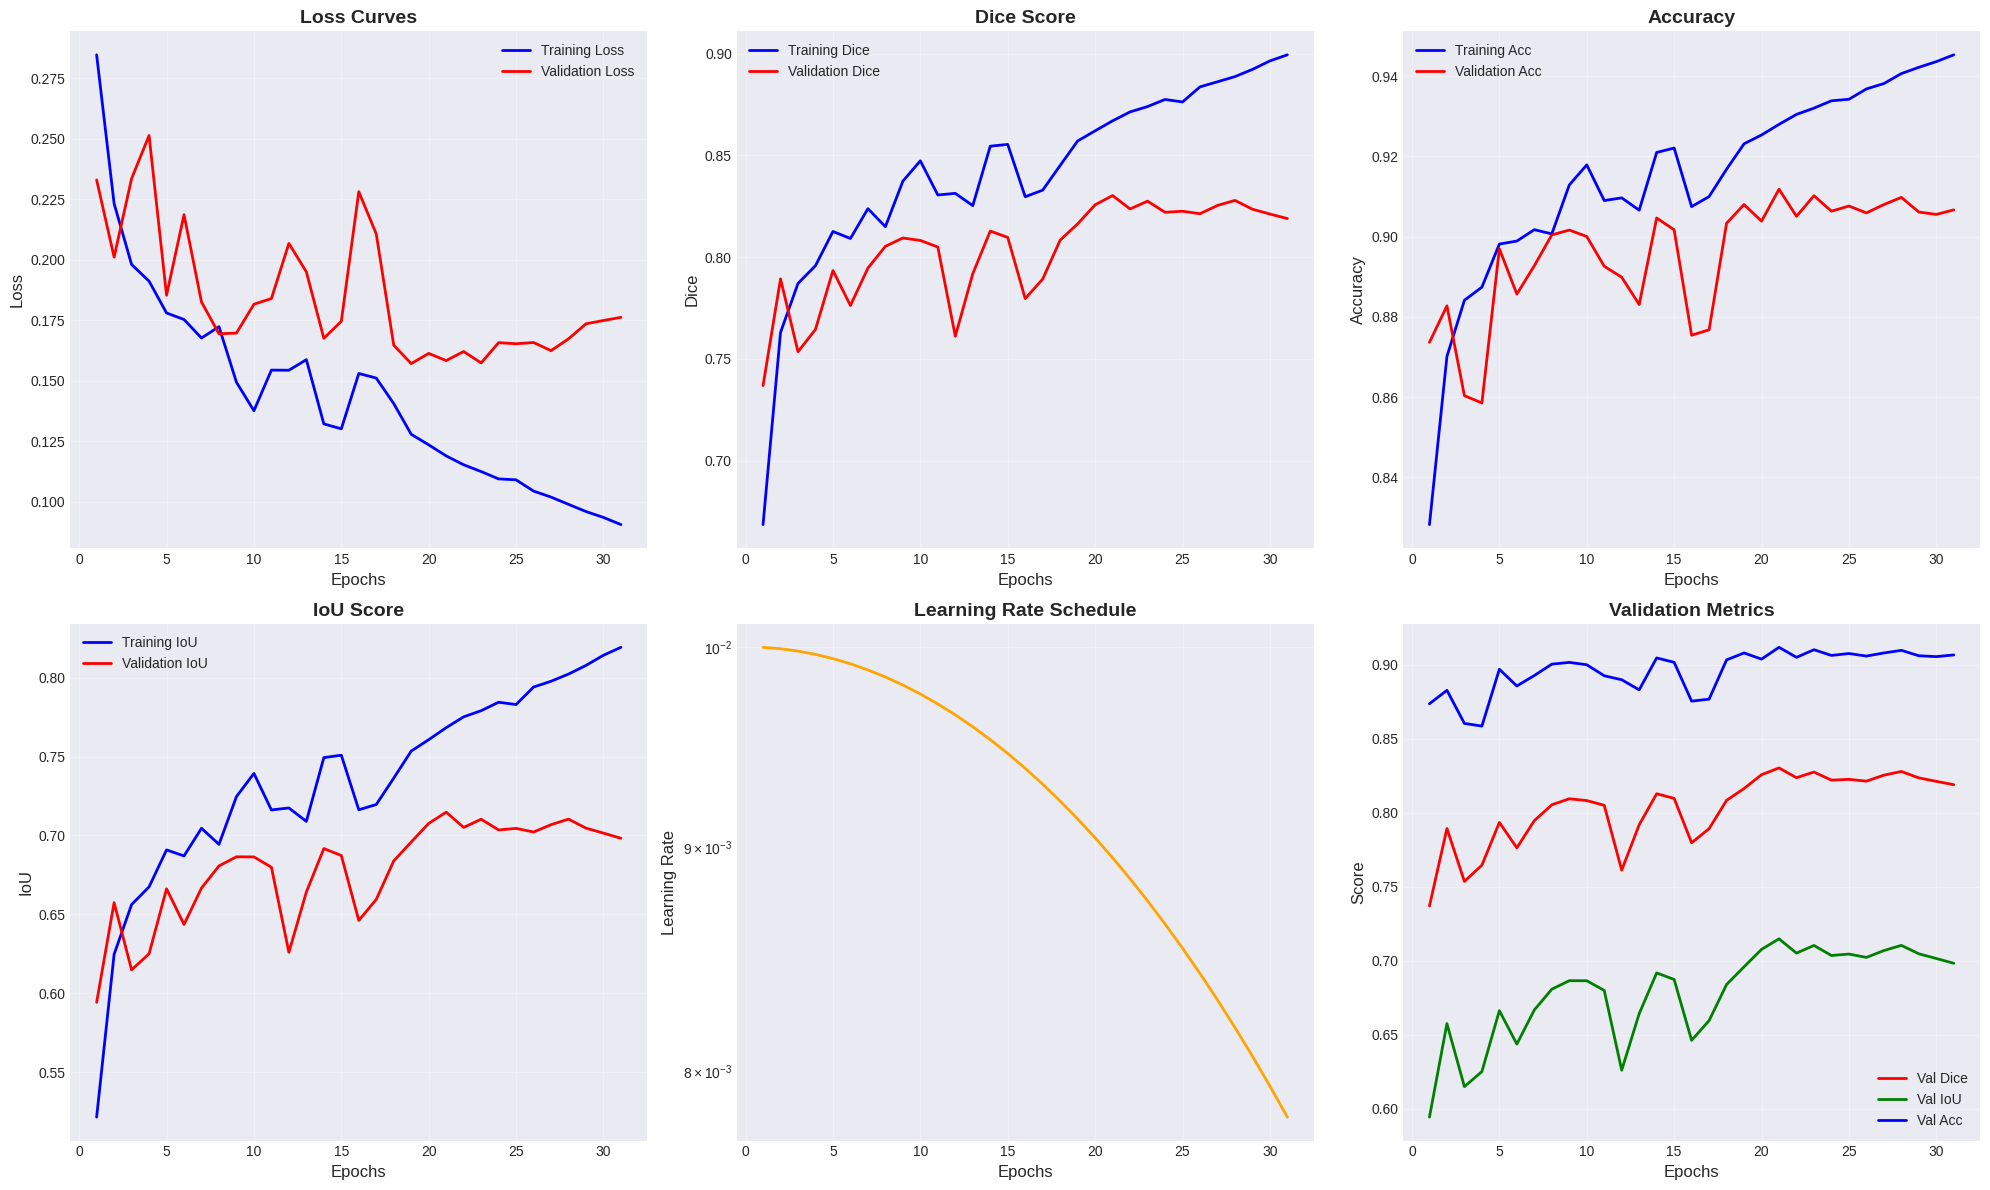

Training plots saved to: /content/model/TU_OilSpill224/training_history.png

TRAINING COMPLETED SUCCESSFULLY


In [50]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

history = enhanced_trainer_oilspill(args, model, snapshot_path)

print("\n" + "="*60)
print("TRAINING COMPLETED SUCCESSFULLY")
print("="*60)

In [51]:
# Save models and results to Google Drive
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"\nSaving results to Google Drive...")
drive_model_path = f"/content/drive/MyDrive/TransUNet_models_{timestamp}"
!cp -r {snapshot_path} {drive_model_path}
print(f"✓ Models saved to: TransUNet_models_{timestamp}")

print(f"\n{'='*60}")
print(f"All results saved successfully with timestamp: {timestamp}")
print(f"{'='*60}\n")


Saving results to Google Drive...
✓ Models saved to: TransUNet_models_20251111_170800

All results saved successfully with timestamp: 20251111_170800



In [52]:
# Configuration for inference
class InferenceArgs:
    img_size = 224
    num_classes = 2
    vit_patches_size = 16
    n_skip = 3
    root_path = '/content/dataset'

inference_args = InferenceArgs()

# Get model configuration
test_config = get_r50_b16_config()
test_config.n_classes = inference_args.num_classes
test_config.n_skip = inference_args.n_skip
test_config.patches.grid = (inference_args.img_size // inference_args.vit_patches_size,
                            inference_args.img_size // inference_args.vit_patches_size)

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference_model = VisionTransformer(test_config, img_size=inference_args.img_size,
                                    num_classes=inference_args.num_classes).to(device)

# Load best model weights
best_model_path = f'/content/model/TU_OilSpill{inference_args.img_size}/best_model.pth'
inference_model.load_state_dict(torch.load(best_model_path, map_location=device))
inference_model.eval()

print(f"✓ Model loaded from: {best_model_path}")

✓ Model loaded from: /content/model/TU_OilSpill224/best_model.pth


In [53]:
# Dataset class for test data
class TestOilSpillDataset(Dataset):
    def __init__(self, base_dir, split='test', sensor='sentinel', transform=None):
        dataset_path = os.path.join(base_dir, 'dataset')
        self.image_dir = os.path.join(dataset_path, split, sensor, 'image')
        self.label_dir = os.path.join(dataset_path, split, sensor, 'label')

        if not os.path.exists(self.image_dir):
            print(f"Warning: Image directory not found: {self.image_dir}")
            self.image_filenames = []
        else:
            self.image_filenames = sorted([f for f in os.listdir(self.image_dir)
                                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

        self.label_exists = os.path.exists(self.label_dir)
        self.transform = transform

        print(f"Found {len(self.image_filenames)} test images")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_filename)

        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")

        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = None
        if self.label_exists:
            label_path = os.path.join(self.label_dir, img_filename)
            if os.path.exists(label_path):
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = (label > 127).astype(np.uint8)

        image = image.astype(np.float32)
        if image.max() > 1.0:
            image = image / 255.0

        sample = {
            'image': image,
            'label': label,
            'case_name': os.path.splitext(img_filename)[0]
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

# Transform for test data
class TestTransform:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label, case_name = sample['image'], sample['label'], sample['case_name']

        image = cv2.resize(image, self.output_size, interpolation=cv2.INTER_LINEAR)

        if label is not None:
            label = cv2.resize(label, self.output_size, interpolation=cv2.INTER_NEAREST)

        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image.astype(np.float32))

        if label is not None:
            label = torch.from_numpy(label.astype(np.uint8)).long()

        return {'image': image, 'label': label, 'case_name': case_name}

# Create test dataset
test_transform = TestTransform(output_size=(inference_args.img_size, inference_args.img_size))
test_dataset = TestOilSpillDataset(
    base_dir=inference_args.root_path,
    split='test',
    sensor='sentinel',
    transform=test_transform
)

# Create subset of 20 samples
num_samples = min(20, len(test_dataset))
test_subset = torch.utils.data.Subset(test_dataset, list(range(num_samples)))
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False, num_workers=2)

print(f"✓ Created test loader with {num_samples} samples")

Found 839 test images
✓ Created test loader with 20 samples



RUNNING INFERENCE ON TEST SAMPLES



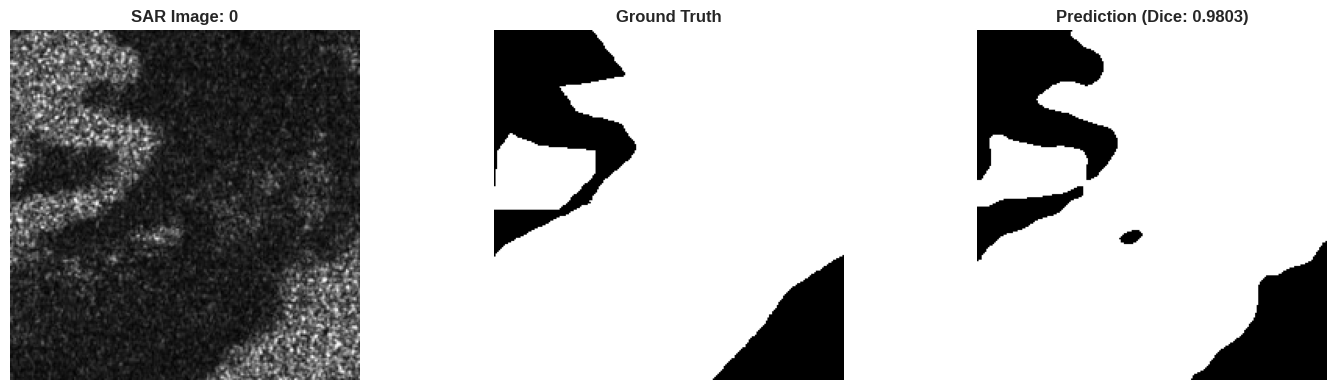

Processed sample 1/20: 0


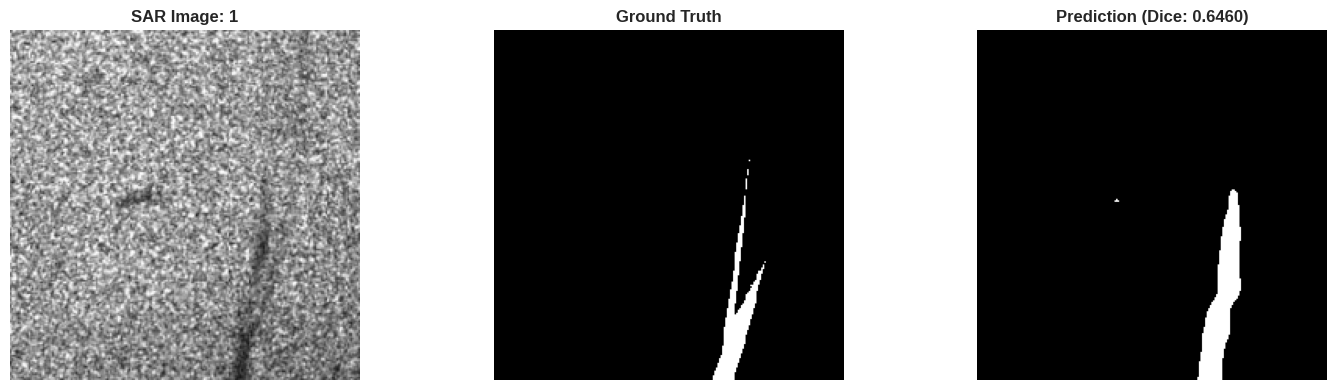

Processed sample 2/20: 1


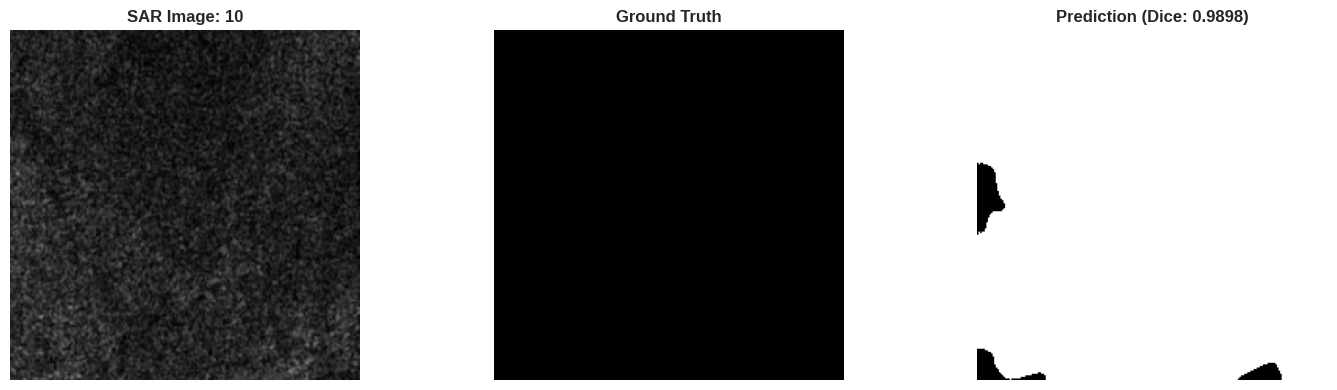

Processed sample 3/20: 10


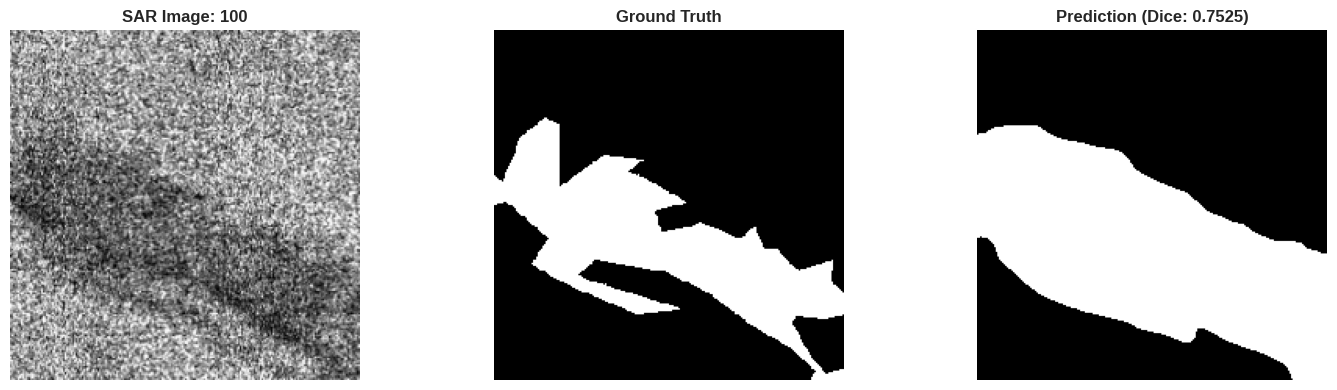

Processed sample 4/20: 100


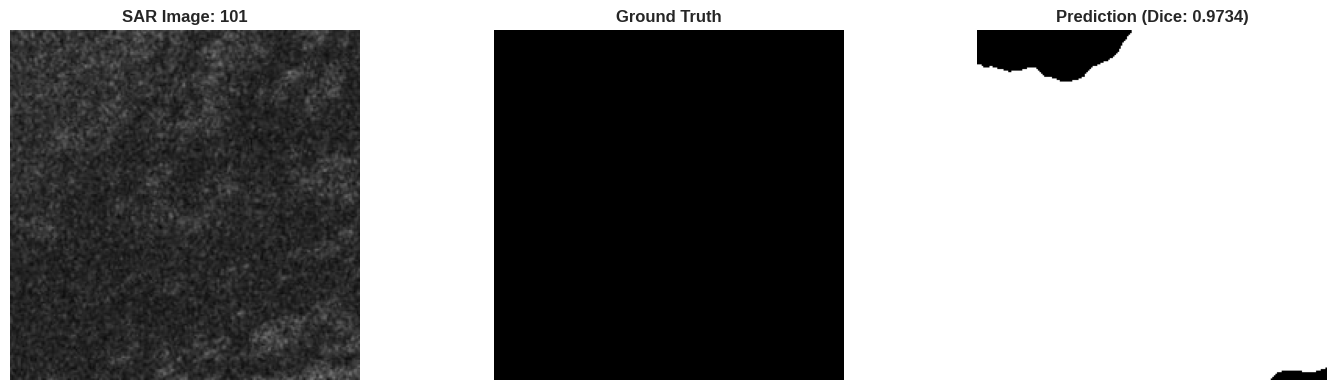

Processed sample 5/20: 101


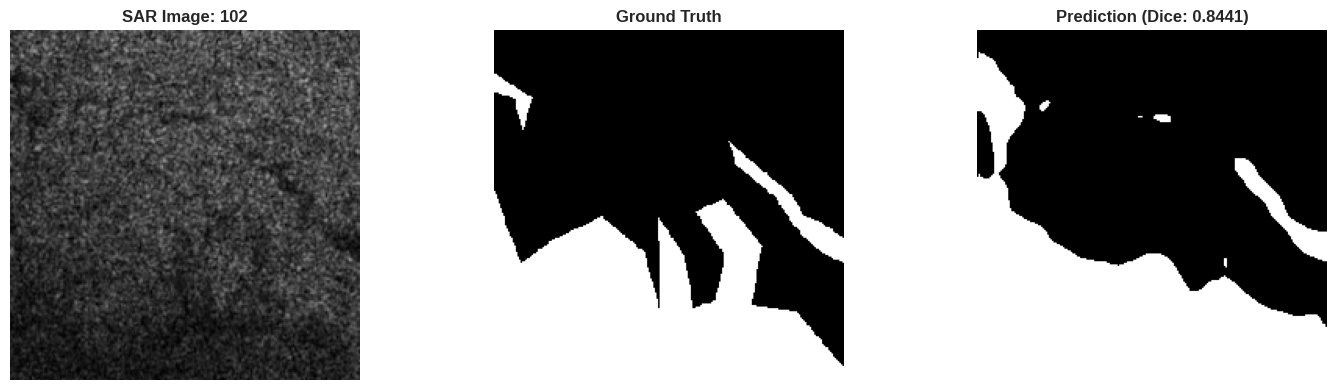

Processed sample 6/20: 102


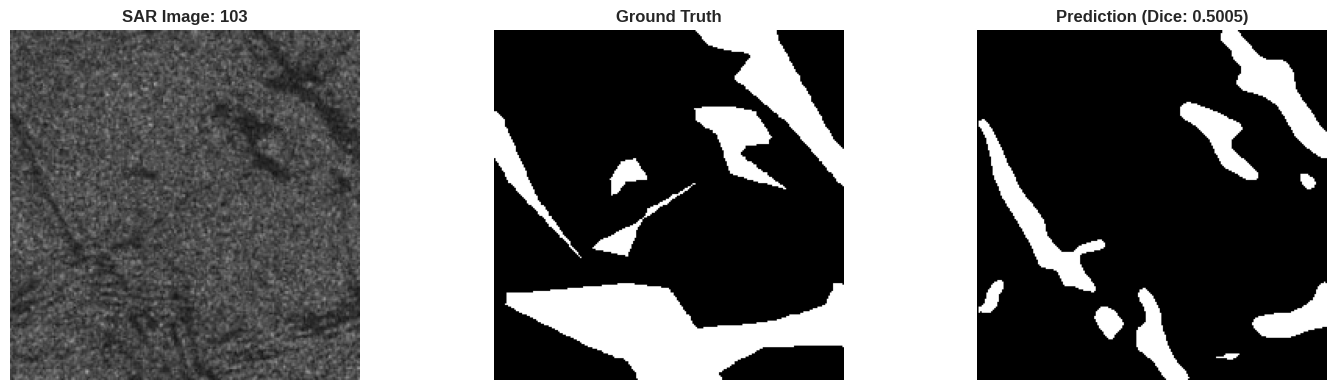

Processed sample 7/20: 103


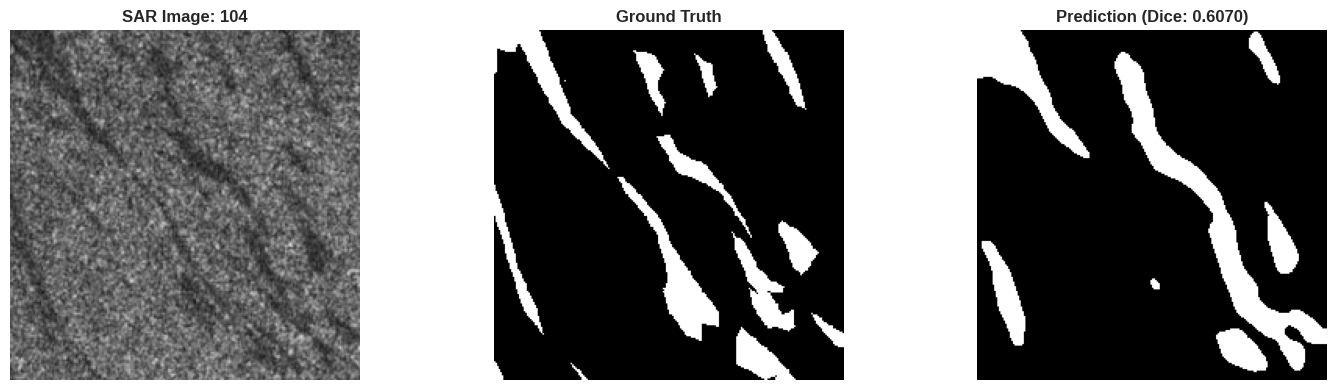

Processed sample 8/20: 104


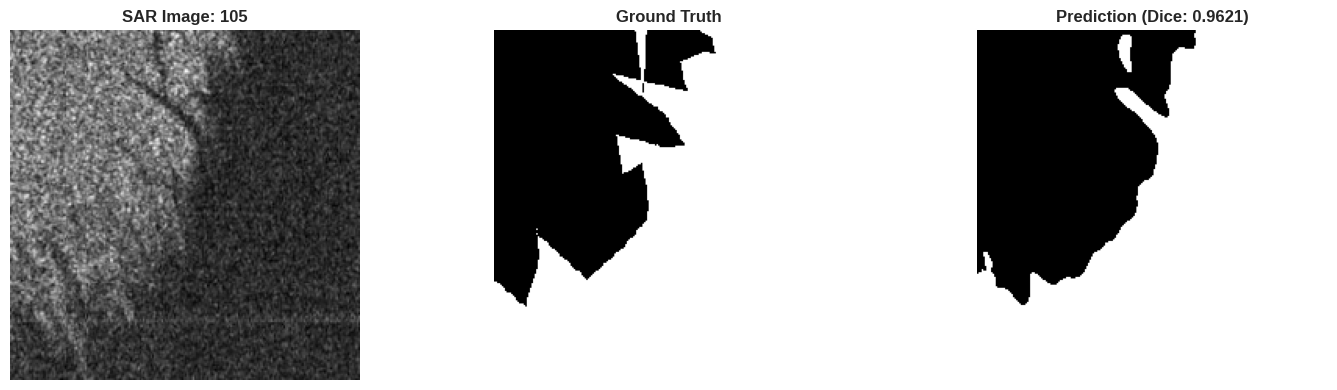

Processed sample 9/20: 105


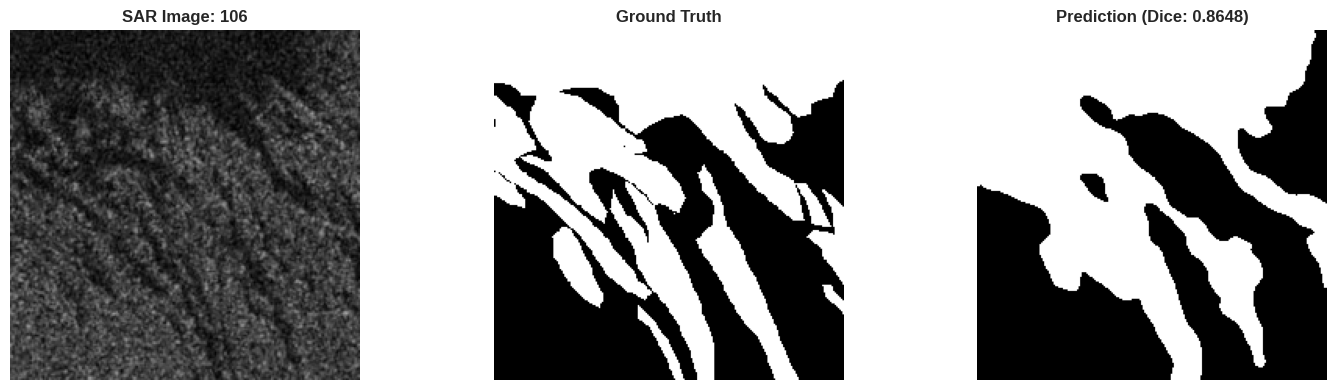

Processed sample 10/20: 106


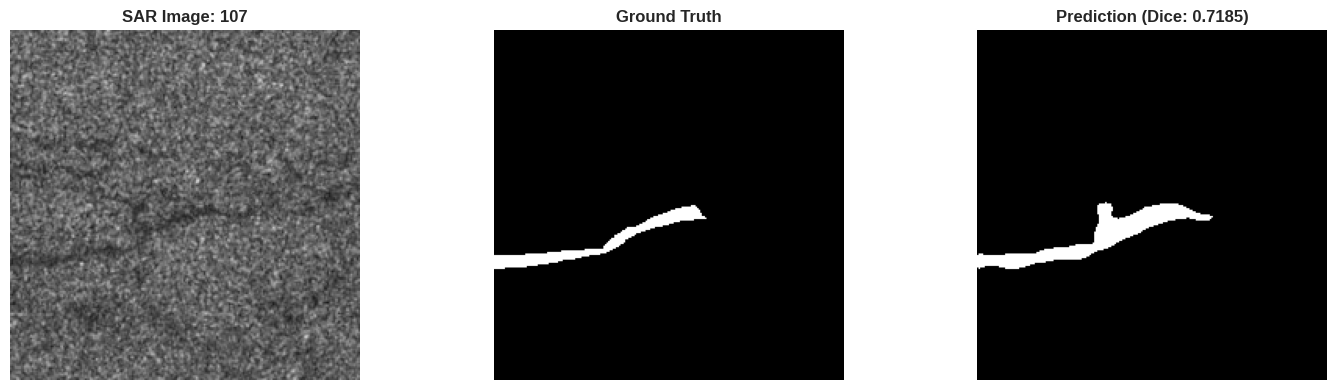

Processed sample 11/20: 107


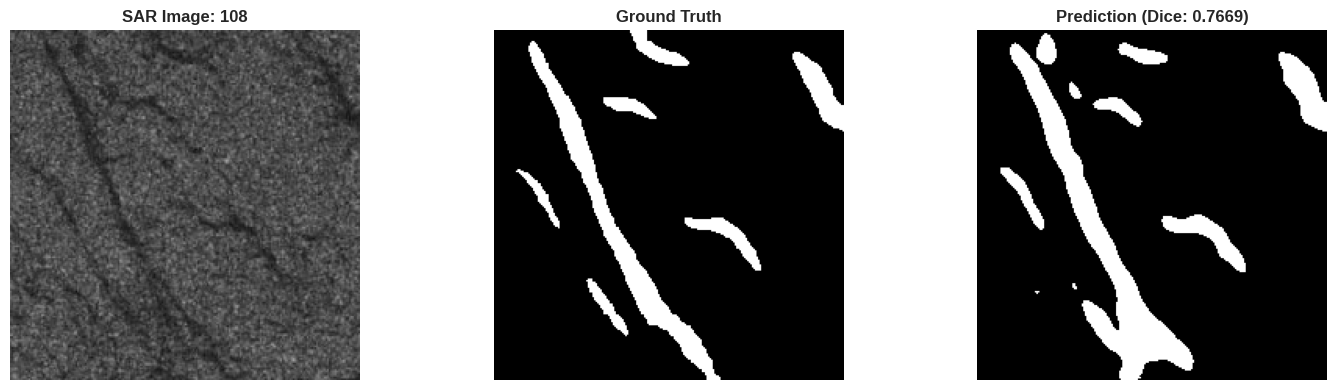

Processed sample 12/20: 108


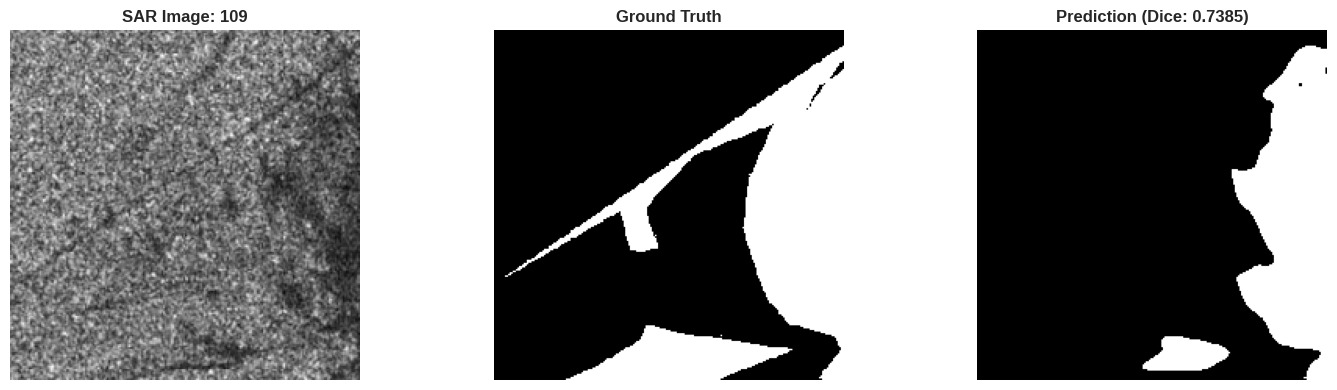

Processed sample 13/20: 109


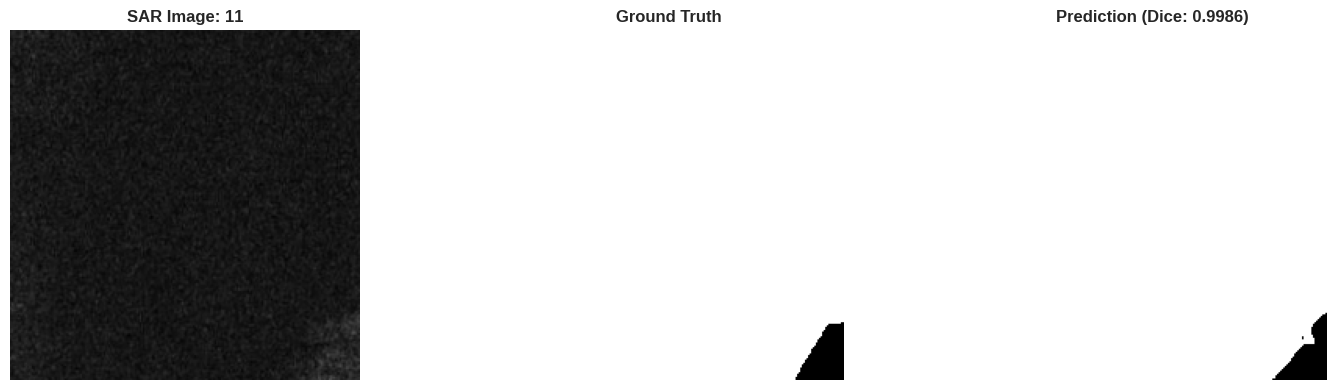

Processed sample 14/20: 11


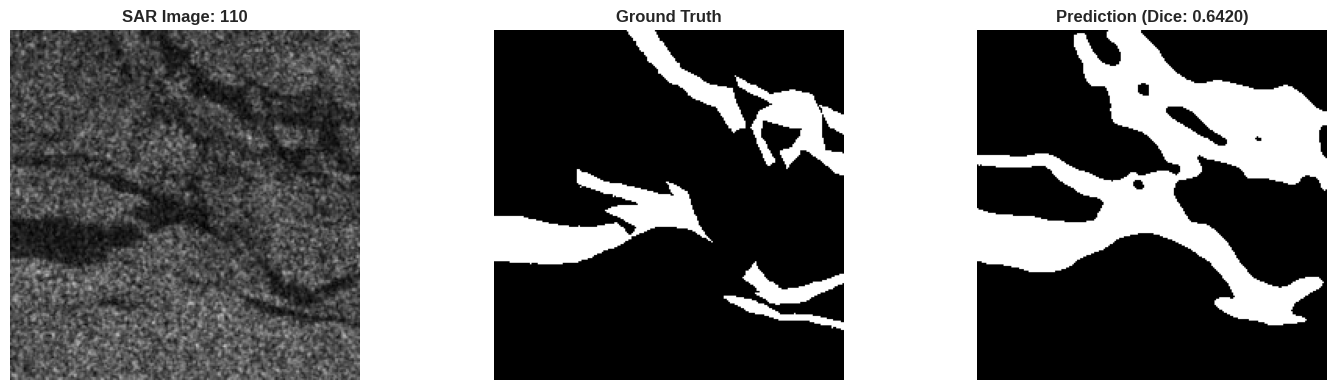

Processed sample 15/20: 110


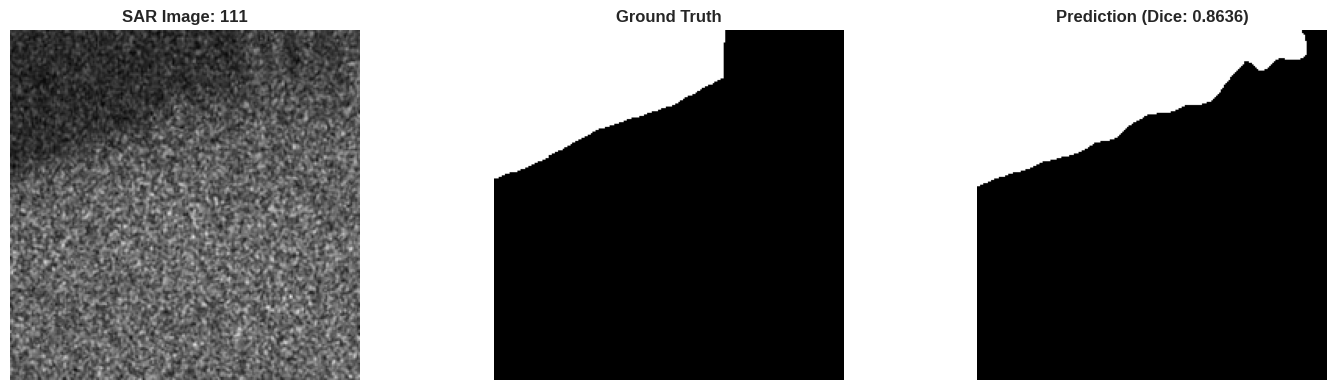

Processed sample 16/20: 111


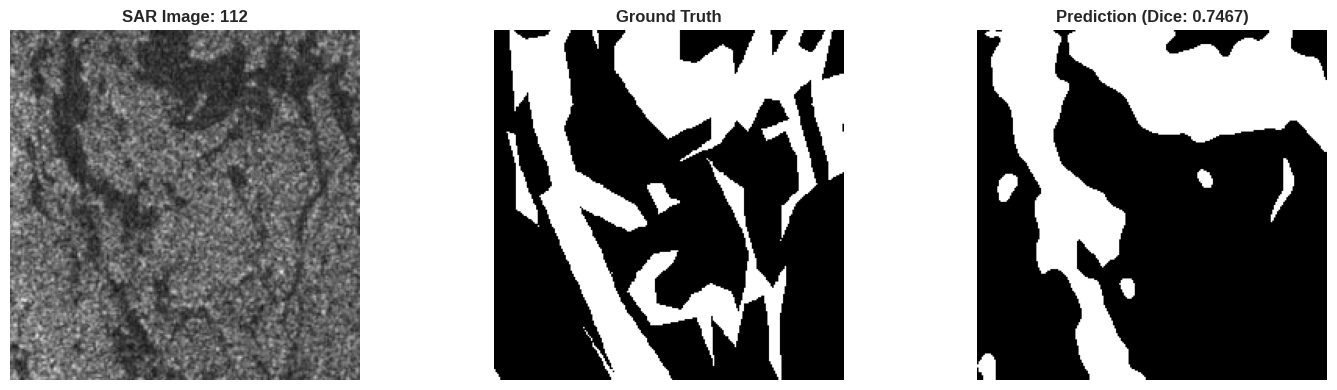

Processed sample 17/20: 112


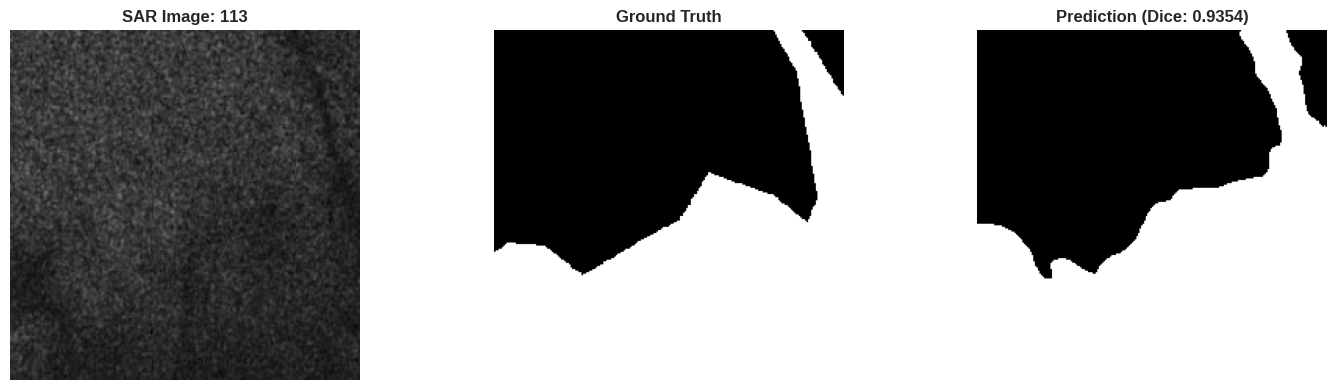

Processed sample 18/20: 113


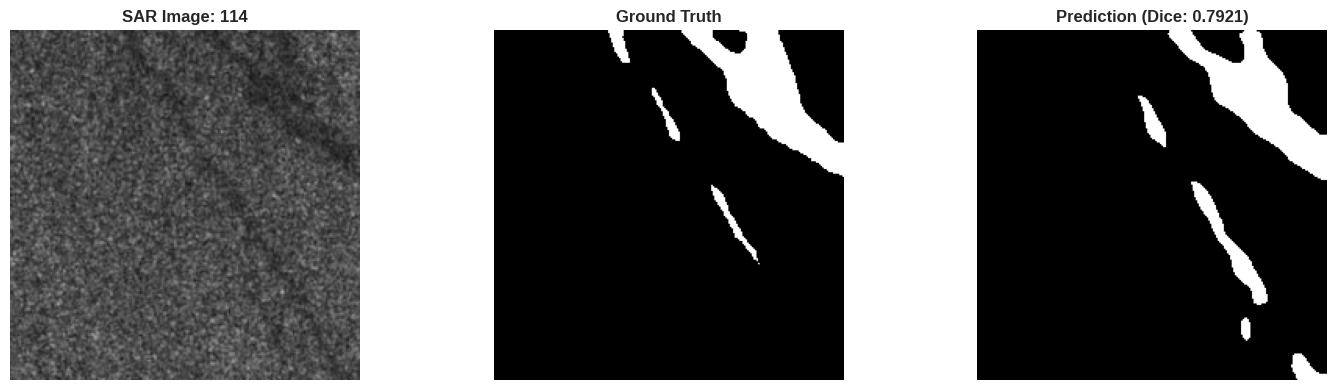

Processed sample 19/20: 114


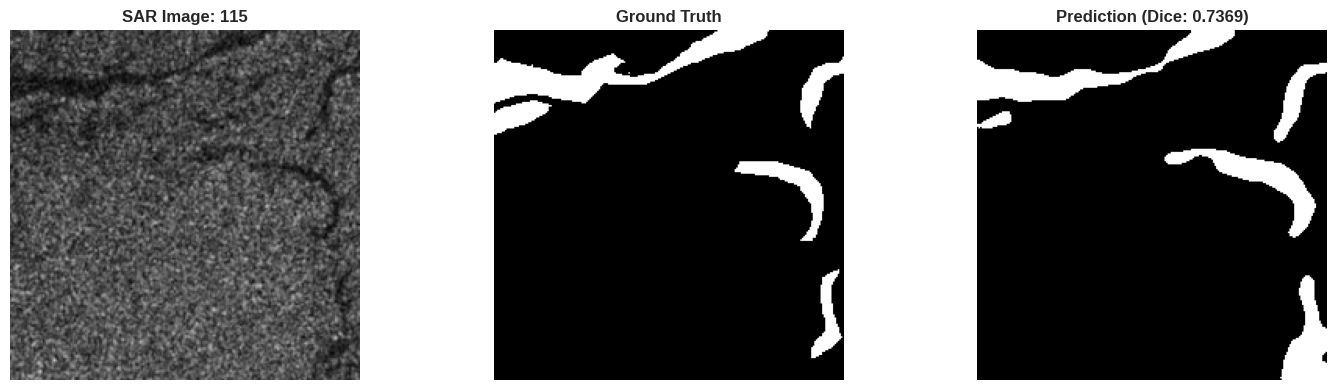

Processed sample 20/20: 115

INFERENCE COMPLETED


In [54]:
print("\n" + "="*60)
print("RUNNING INFERENCE ON TEST SAMPLES")
print("="*60 + "\n")

total_correct = 0
total_pixels = 0
dice_numer = 0.0
dice_denom = 0.0
results = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images = batch['image'].to(device)
        labels = batch['label']
        case_name = batch['case_name'][0]

        # Run inference
        outputs = inference_model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Calculate metrics if labels exist
        if labels is not None and labels[0] is not None:
            labels = labels.to(device)

            total_correct += (preds == labels).sum().item()
            total_pixels += labels.numel()

            p = (preds > 0).float()
            g = (labels > 0).float()
            intersection = (p * g).sum().item()
            dice_numer += 2 * intersection
            dice_denom += p.sum().item() + g.sum().item()

            # Store results
            results.append({
                'case_name': case_name,
                'dice': (2 * intersection) / (p.sum().item() + g.sum().item() + 1e-8),
                'has_label': True
            })
        else:
            results.append({
                'case_name': case_name,
                'dice': None,
                'has_label': False
            })

        # Prepare images for visualization
        sar_img = images[0].cpu().numpy().transpose(1, 2, 0)
        sar_img = (sar_img * 255).astype(np.uint8)
        pred_img = preds[0].cpu().numpy() * 255

        # Create visualization
        if labels is not None and labels[0] is not None:
            gt_img = labels[0].cpu().numpy() * 255

            plt.figure(figsize=(15, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(sar_img)
            plt.title(f'SAR Image: {case_name}', fontsize=12, fontweight='bold')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(gt_img, cmap='gray')
            plt.title('Ground Truth', fontsize=12, fontweight='bold')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_img, cmap='gray')
            dice_score = results[-1]['dice']
            plt.title(f'Prediction (Dice: {dice_score:.4f})', fontsize=12, fontweight='bold')
            plt.axis('off')
        else:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(sar_img)
            plt.title(f'SAR Image: {case_name}', fontsize=12, fontweight='bold')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(pred_img, cmap='gray')
            plt.title('Prediction', fontsize=12, fontweight='bold')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Processed sample {i+1}/{num_samples}: {case_name}")

print("\n" + "="*60)
print("INFERENCE COMPLETED")
print("="*60)


OVERALL METRICS ON 20 SAMPLES
  Pixel Accuracy: 91.79%
  Dice Score: 0.8955
  Total Pixels: 1,003,520



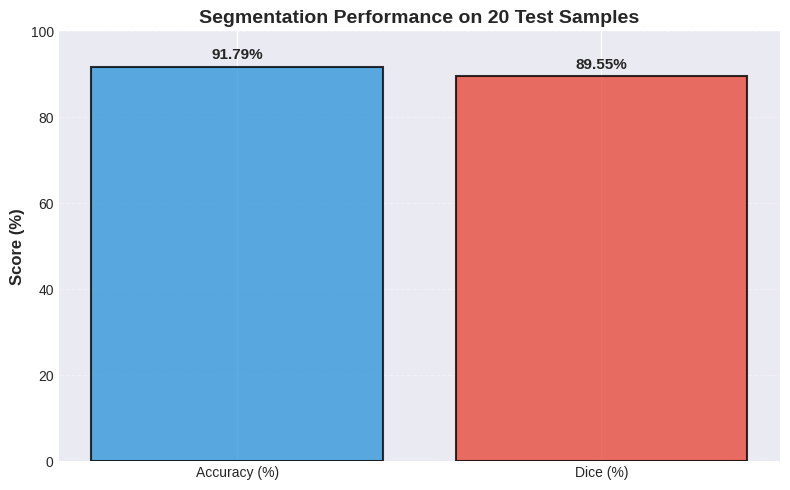

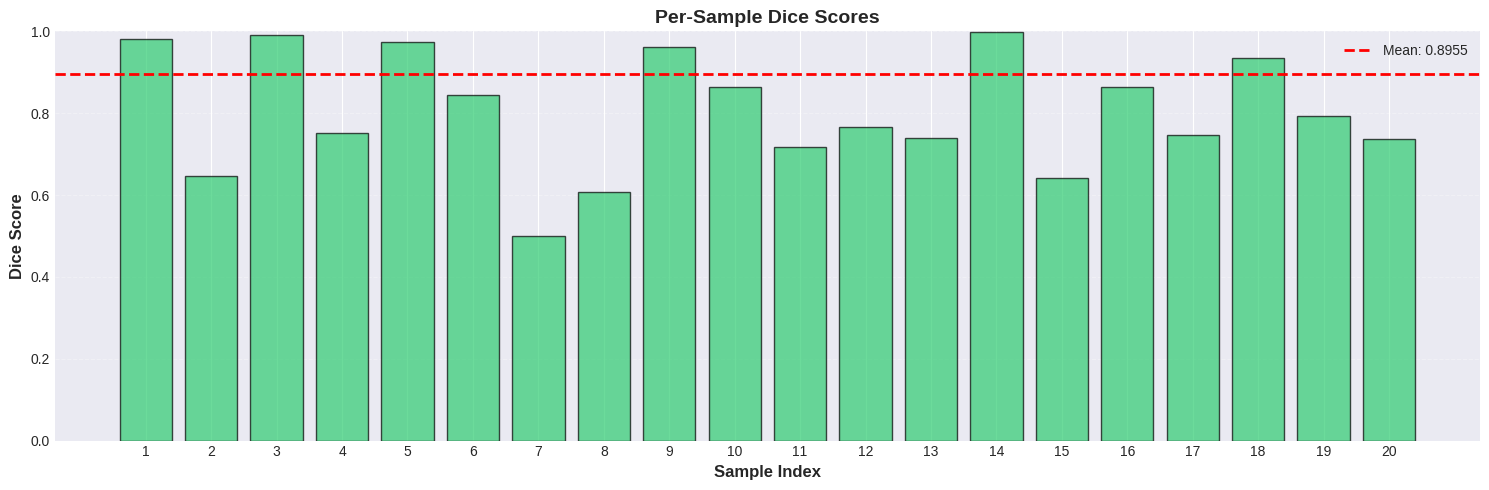

In [55]:
# Calculate overall metrics
if total_pixels > 0:
    overall_acc = total_correct / total_pixels
    overall_dice = dice_numer / dice_denom if dice_denom > 0 else 0

    print(f"\n{'='*60}")
    print(f"OVERALL METRICS ON {num_samples} SAMPLES")
    print(f"{'='*60}")
    print(f"  Pixel Accuracy: {overall_acc*100:.2f}%")
    print(f"  Dice Score: {overall_dice:.4f}")
    print(f"  Total Pixels: {total_pixels:,}")
    print(f"{'='*60}\n")

    # Plot summary bar chart
    plt.figure(figsize=(8, 5))
    metrics = ['Accuracy (%)', 'Dice (%)']
    values = [overall_acc*100, overall_dice*100]
    bars = plt.bar(metrics, values, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)

    plt.ylim(0, 100)
    plt.ylabel('Score (%)', fontsize=12, fontweight='bold')
    plt.title(f'Segmentation Performance on {num_samples} Test Samples', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{value:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Plot individual sample performance
    sample_dice = [r['dice'] for r in results if r['has_label']]
    sample_names = [r['case_name'] for r in results if r['has_label']]

    if len(sample_dice) > 0:
        plt.figure(figsize=(15, 5))
        bars = plt.bar(range(len(sample_dice)), sample_dice, color='#2ecc71', alpha=0.7, edgecolor='black')
        plt.xlabel('Sample Index', fontsize=12, fontweight='bold')
        plt.ylabel('Dice Score', fontsize=12, fontweight='bold')
        plt.title('Per-Sample Dice Scores', fontsize=14, fontweight='bold')
        plt.xticks(range(len(sample_dice)), range(1, len(sample_dice)+1))
        plt.ylim(0, 1.0)
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        plt.axhline(y=overall_dice, color='r', linestyle='--', linewidth=2, label=f'Mean: {overall_dice:.4f}')
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("\n⚠ No labels found for evaluation. Only predictions were generated.")
    print(f"Generated predictions for {num_samples} samples.")

In [56]:
# ============================================================================
# TRANSUNET REAL-TIME SHAPE TRACER USING FORWARD HOOKS
# ============================================================================

# Storage for captured shapes
shape_registry = {}
hook_handles = []

def register_shape_hook(module, name):
    """Register a forward hook to capture input/output shapes"""
    def hook_fn(mod, inp, out):
        # Handle tuple inputs/outputs
        in_shape = inp[0].shape if isinstance(inp, tuple) else inp.shape

        if isinstance(out, tuple):
            out_shape = out[0].shape if len(out) > 0 else None
        else:
            out_shape = out.shape

        shape_registry[name] = {
            'input': tuple(in_shape),
            'output': tuple(out_shape) if out_shape is not None else None
        }

    handle = module.register_forward_hook(hook_fn)
    hook_handles.append(handle)
    return handle

# ============================================================================
# REGISTER HOOKS ON EXISTING MODEL
# ============================================================================

print("="*80)
print("REGISTERING FORWARD HOOKS ON TRANSUNET")
print("="*80 + "\n")

# 1. ResNet Backbone Stages
register_shape_hook(model.transformer.embeddings.hybrid_model.root[0], "1_ResNet_RootConv7x7")
register_shape_hook(model.transformer.embeddings.hybrid_model.root[1], "2_ResNet_GroupNorm")

# MaxPool (need to hook it differently since it's applied in forward)
# We'll capture it via the body blocks

# 2. ResNet Blocks
register_shape_hook(model.transformer.embeddings.hybrid_model.body[0], "3_ResNet_Block1")
register_shape_hook(model.transformer.embeddings.hybrid_model.body[1], "4_ResNet_Block2")
register_shape_hook(model.transformer.embeddings.hybrid_model.body[2], "5_ResNet_Block3")

# 3. Patch Embeddings
register_shape_hook(model.transformer.embeddings.patch_embeddings, "6_PatchEmbed_Conv")

# 4. Transformer Encoder Blocks
register_shape_hook(model.transformer.encoder.layer[0], "7_TransformerBlock_01")
register_shape_hook(model.transformer.encoder.layer[5], "8_TransformerBlock_06_Mid")
register_shape_hook(model.transformer.encoder.layer[11], "9_TransformerBlock_12_Last")

# 5. Encoder Norm
register_shape_hook(model.transformer.encoder.encoder_norm, "10_Encoder_LayerNorm")

# 6. Decoder Stages
register_shape_hook(model.decoder.conv_more, "11_Decoder_ConvMore")
register_shape_hook(model.decoder.blocks[0], "12_DecoderBlock_1")
register_shape_hook(model.decoder.blocks[1], "13_DecoderBlock_2")
register_shape_hook(model.decoder.blocks[2], "14_DecoderBlock_3")
register_shape_hook(model.decoder.blocks[3], "15_DecoderBlock_4")

# 7. Segmentation Head
register_shape_hook(model.segmentation_head[0], "16_SegHead_FinalConv")

print(f"✓ Registered {len(hook_handles)} forward hooks\n")

# ============================================================================
# RUN FORWARD PASS WITH REAL DATA
# ============================================================================

print("="*80)
print("RUNNING FORWARD PASS TO CAPTURE SHAPES")
print("="*80 + "\n")

# Get a test sample
test_sample = test_dataset[0]
if isinstance(test_sample, dict):
    test_image = test_sample['image']
    test_label = test_sample['label']
else:
    test_image, test_label = test_sample

# Prepare input
test_input = test_image.unsqueeze(0).to(device)
print(f"Input tensor shape: {test_input.shape}\n")

# Clear registry
shape_registry.clear()

# Forward pass
with torch.no_grad():
    output = model(test_input)
    prediction = torch.argmax(torch.softmax(output, dim=1), dim=1)

print(f"Output shape: {output.shape}")
print(f"Prediction shape: {prediction.shape}\n")

# ============================================================================
# DISPLAY SHAPE TRANSFORMATIONS IN TABLE FORMAT
# ============================================================================

print("="*80)
print("LAYER-WISE SHAPE TRANSFORMATIONS")
print("="*80 + "\n")

# Print header
print(f"{'Layer Name':<35} {'Input Shape':<25} {'Output Shape':<25}")
print("-" * 85)

# Print shapes in order
for name in sorted(shape_registry.keys()):
    info = shape_registry[name]
    layer_name = name.split('_', 1)[1]  # Remove number prefix
    in_shape = str(list(info['input']))
    out_shape = str(list(info['output']))
    print(f"{layer_name:<35} {in_shape:<25} {out_shape:<25}")

# ============================================================================
# DETAILED ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("DETAILED ARCHITECTURE ANALYSIS")
print("="*80 + "\n")

# Calculate patch count
patch_embed_out = shape_registry.get("6_PatchEmbed_Conv", {}).get('output')
if patch_embed_out:
    _, C, H, W = patch_embed_out
    num_patches = H * W
    print(f"📊 Patch Information:")
    print(f"   - Patch grid: {H} × {W}")
    print(f"   - Total patches (tokens): {num_patches}")
    print(f"   - Hidden dimension: {C}")
    print(f"   - After flatten: [Batch, {num_patches}, {C}]")
    print()

# Check transformer consistency
trans_shapes = []
for name in sorted(shape_registry.keys()):
    if 'TransformerBlock' in name:
        out_shape = shape_registry[name]['output']
        trans_shapes.append(out_shape)

if trans_shapes:
    print(f"🔄 Transformer Block Consistency:")
    all_same = all(s == trans_shapes[0] for s in trans_shapes)
    print(f"   - All transformer blocks have same shape: {all_same}")
    if all_same:
        print(f"   - Consistent shape: {list(trans_shapes[0])}")
    print(f"   - Number of sampled blocks: {len(trans_shapes)}")
    print()

# Check for CLS token
encoder_out = shape_registry.get("10_Encoder_LayerNorm", {}).get('output')
if encoder_out:
    _, N, C = encoder_out
    print(f"🎯 Token Analysis:")
    print(f"   - Encoder output tokens: {N}")
    print(f"   - Expected tokens (no CLS): {num_patches}")
    print(f"   - CLS token present: {'YES' if N > num_patches else 'NO'}")
    print(f"   - Shape: [Batch, {N}, {C}]")
    print()

# Positional embeddings
pos_emb_shape = model.transformer.embeddings.position_embeddings.shape
print(f"📍 Positional Embeddings:")
print(f"   - Shape: {list(pos_emb_shape)}")
print(f"   - Matches token count: {pos_emb_shape[1] == num_patches}")
print()

# Skip connections info
print(f"🔗 Skip Connections (from model config):")
print(f"   - Number of skip connections: {model.config.n_skip}")
print(f"   - Skip channels: {model.config.skip_channels}")
print()

# Decoder upsampling path
decoder_shapes = []
for i in range(4):
    key = f"{12+i}_DecoderBlock_{i+1}"
    if key in shape_registry:
        out_shape = shape_registry[key]['output']
        decoder_shapes.append(out_shape)

if decoder_shapes:
    print(f"⬆️  Decoder Upsampling Path:")
    for i, shape in enumerate(decoder_shapes):
        _, C, H, W = shape
        print(f"   - Block {i+1}: [{C} channels, {H}×{W}]")
    print()

# Final output
seg_out = shape_registry.get("16_SegHead_FinalConv", {}).get('output')
if seg_out:
    _, num_classes, H, W = seg_out
    print(f"🎨 Segmentation Output:")
    print(f"   - Number of classes: {num_classes}")
    print(f"   - Output resolution: {H}×{W}")
    print(f"   - Shape: {list(seg_out)}")
    print()

# ============================================================================
# SHAPE FLOW DIAGRAM
# ============================================================================

print("="*80)
print("ARCHITECTURE FLOW DIAGRAM")
print("="*80 + "\n")

print("""
INPUT IMAGE [1, 3, 224, 224]
    │
    ├─► ResNet Root Conv 7×7, stride=2    → [1, 64, 112, 112]
    │
    ├─► ResNet Block 1 (3 layers)         → [1, 256, 56, 56]    ◄─┐
    │                                                              │
    ├─► ResNet Block 2 (4 layers)         → [1, 512, 28, 28]    ◄─┤ Skip
    │                                                              │ Connections
    ├─► ResNet Block 3 (9 layers)         → [1, 1024, 14, 14]   ◄─┘
    │
    ├─► Patch Embedding Conv 1×1          → [1, 768, 14, 14]
    │
    ├─► Flatten + Transpose               → [1, 196, 768]
    │
    ├─► Add Positional Embedding          → [1, 196, 768]
    │
    ├─► 12× Transformer Blocks            → [1, 196, 768]
    │      • Multi-Head Self-Attention
    │      • Feed-Forward Network
    │
    ├─► Reshape to Feature Map            → [1, 768, 14, 14]
    │
    ├─► Decoder ConvMore                  → [1, 512, 14, 14]
    │
    ├─► Decoder Block 1 + Skip            → [1, 256, 28, 28]
    │
    ├─► Decoder Block 2 + Skip            → [1, 128, 56, 56]
    │
    ├─► Decoder Block 3 + Skip            → [1, 64, 112, 112]
    │
    ├─► Decoder Block 4 (no skip)         → [1, 16, 224, 224]
    │
    └─► Segmentation Head Conv            → [1, 2, 224, 224]
            │
            └─► Softmax + ArgMax          → [1, 224, 224]
""")

print("="*80)
print("✓ SHAPE TRACING COMPLETED")
print("="*80 + "\n")

# ============================================================================
# CLEANUP HOOKS
# ============================================================================

print("Cleaning up hooks...")
for handle in hook_handles:
    handle.remove()
hook_handles.clear()
shape_registry.clear()
print("✓ All hooks removed\n")

REGISTERING FORWARD HOOKS ON TRANSUNET

✓ Registered 16 forward hooks

RUNNING FORWARD PASS TO CAPTURE SHAPES

Input tensor shape: torch.Size([1, 3, 224, 224])

Output shape: torch.Size([1, 2, 224, 224])
Prediction shape: torch.Size([1, 224, 224])

LAYER-WISE SHAPE TRANSFORMATIONS

Layer Name                          Input Shape               Output Shape             
-------------------------------------------------------------------------------------
Encoder_LayerNorm                   [1, 196, 768]             [1, 196, 768]            
Decoder_ConvMore                    [1, 768, 14, 14]          [1, 512, 14, 14]         
DecoderBlock_1                      [1, 512, 14, 14]          [1, 256, 28, 28]         
DecoderBlock_2                      [1, 256, 28, 28]          [1, 128, 56, 56]         
DecoderBlock_3                      [1, 128, 56, 56]          [1, 64, 112, 112]        
DecoderBlock_4                      [1, 64, 112, 112]         [1, 16, 224, 224]        
SegHead_FinalCo

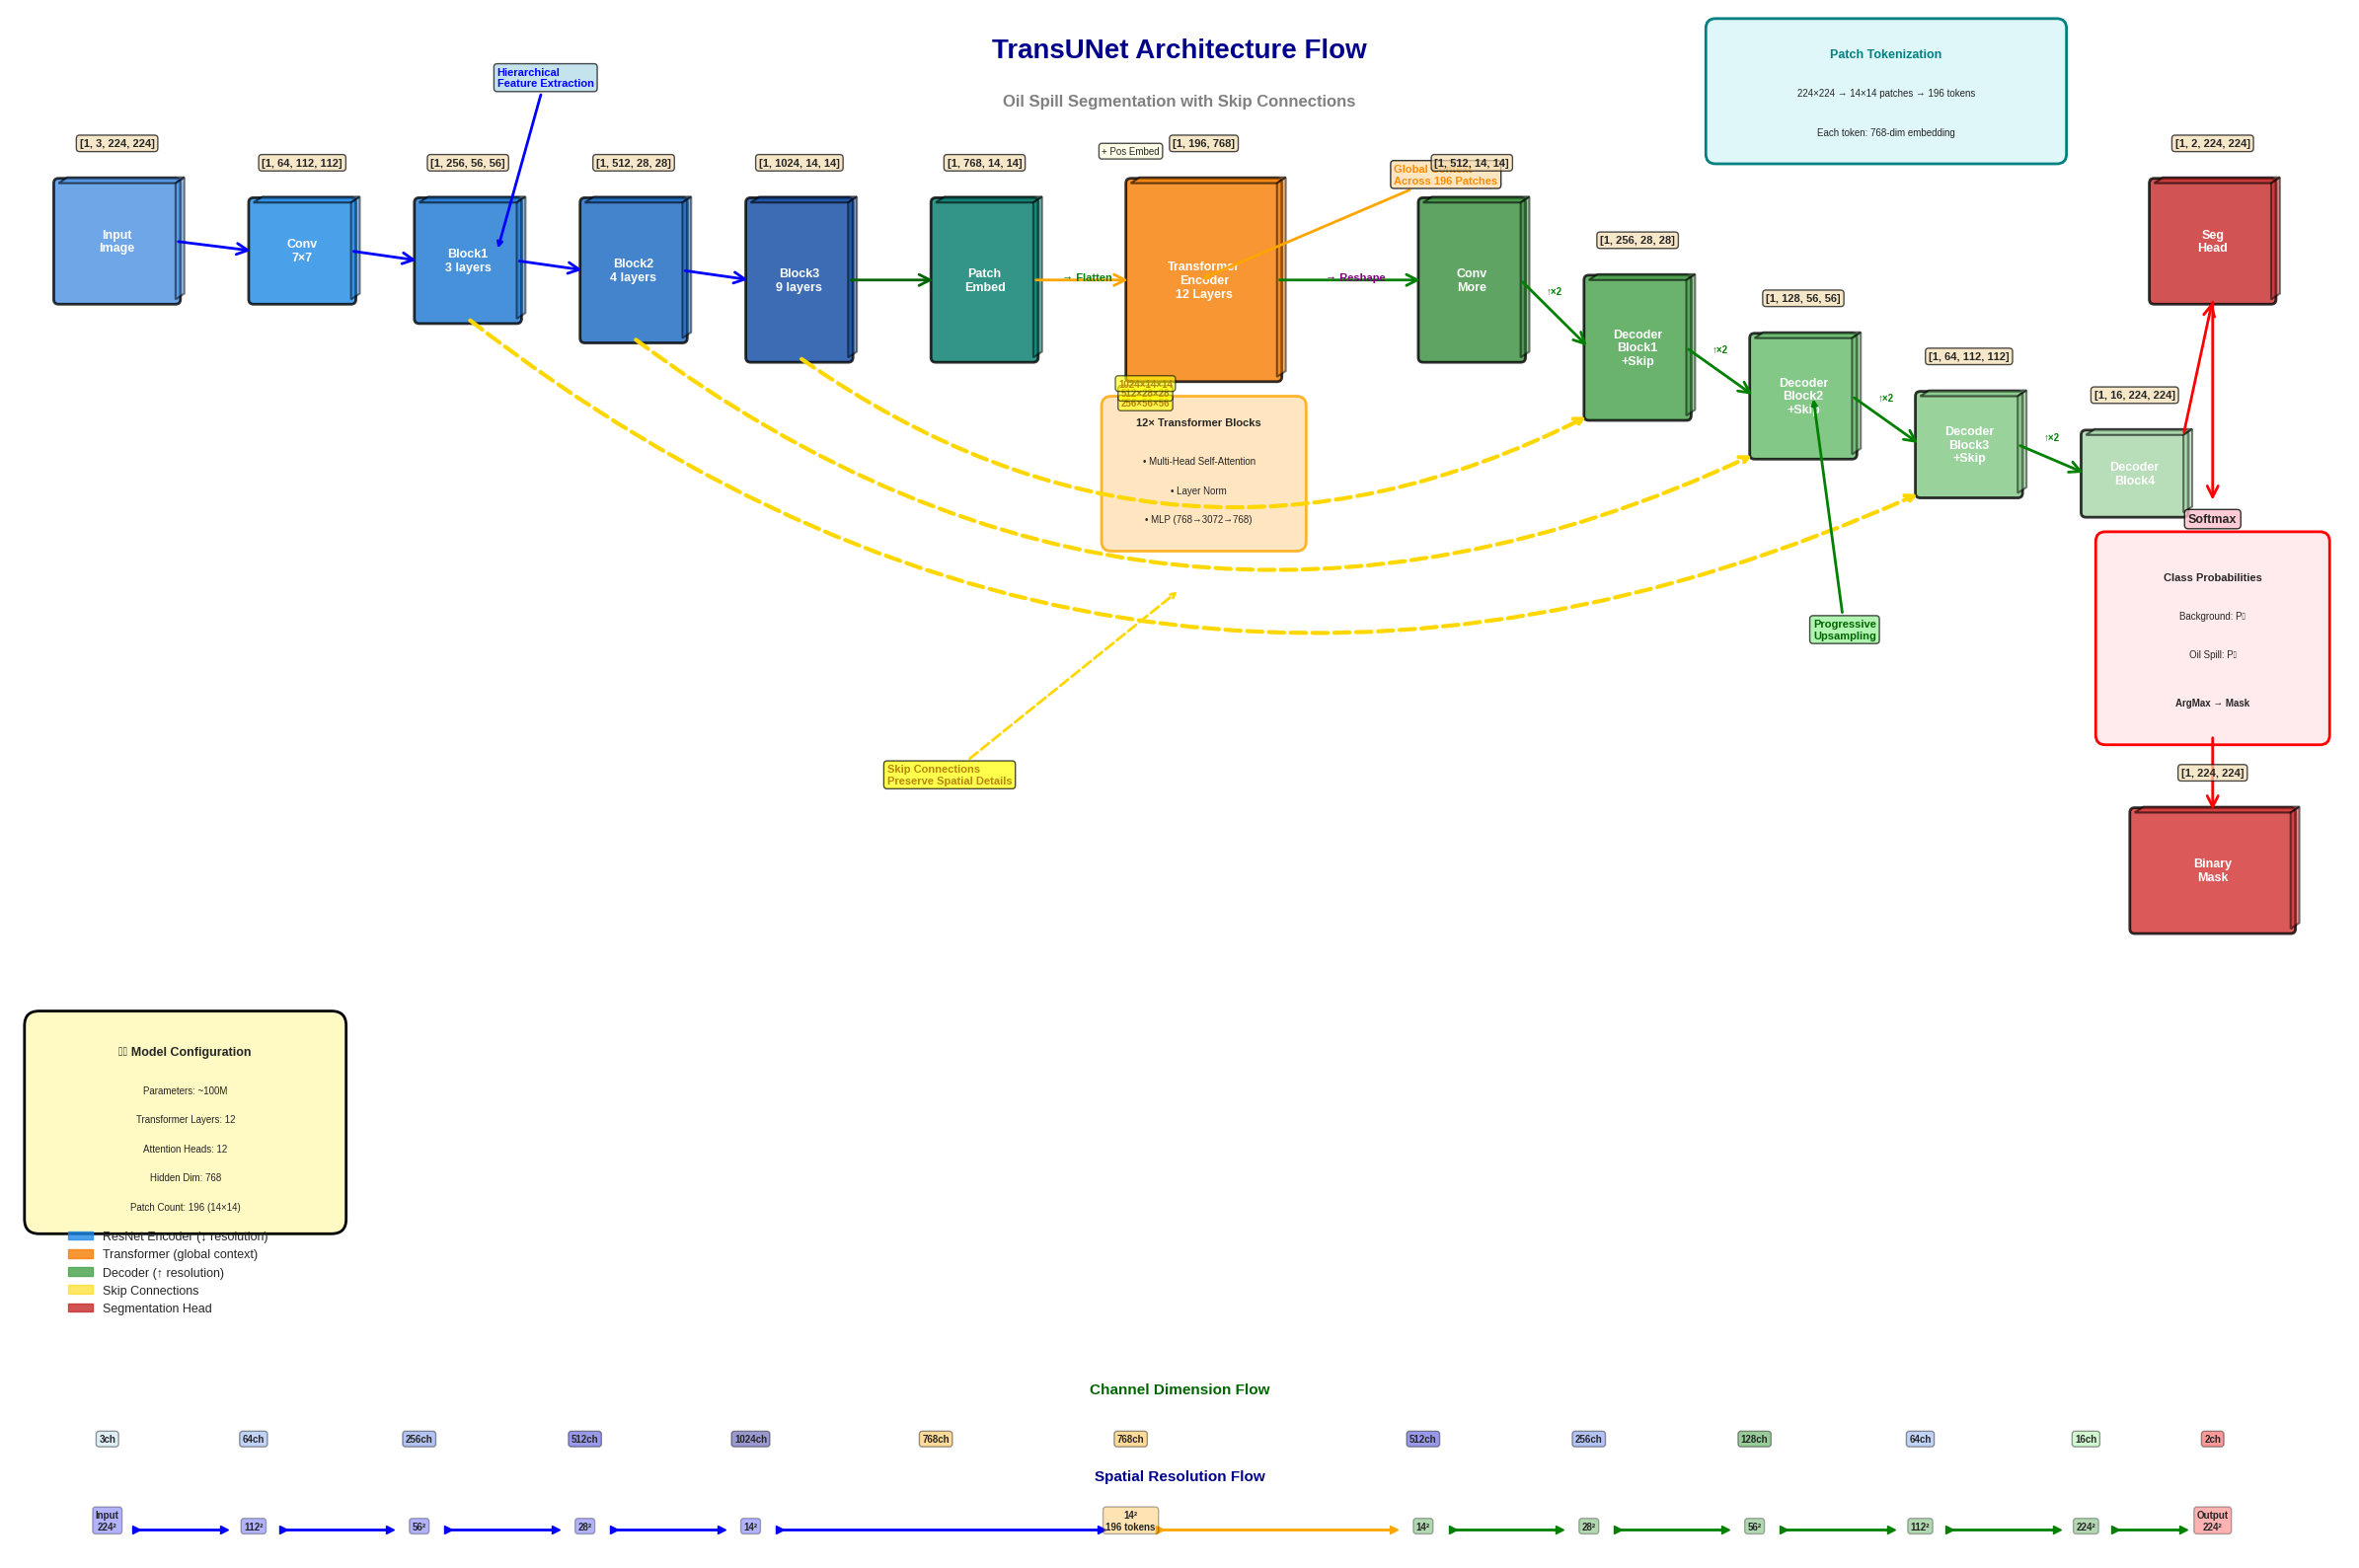

✓ Architecture diagram saved as 'transunet_architecture_diagram.png'


In [57]:
# ============================================================================
# TRANSUNET COMPLETE ARCHITECTURE VISUALIZATION DIAGRAM
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Circle
from matplotlib.patches import Rectangle, ConnectionPatch
import numpy as np

# Create large figure
fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(111)
ax.set_xlim(0, 24)
ax.set_ylim(0, 16)
ax.axis('off')

# ============================================================================
# HELPER FUNCTIONS FOR DRAWING
# ============================================================================

def draw_3d_block(ax, x, y, width, height, depth, color, label, shape_text):
    """Draw a 3D-looking block with shape annotation"""
    # Front face
    front = FancyBboxPatch((x, y), width, height,
                           boxstyle="round,pad=0.05",
                           facecolor=color, edgecolor='black',
                           linewidth=2, alpha=0.8)
    ax.add_patch(front)

    # Top face (3D effect)
    top_x = [x, x + depth*0.3, x + width + depth*0.3, x + width, x]
    top_y = [y + height, y + height + depth*0.2, y + height + depth*0.2, y + height, y + height]
    ax.fill(top_x, top_y, color=color, alpha=0.6, edgecolor='black', linewidth=1.5)

    # Right face (3D effect)
    right_x = [x + width, x + width + depth*0.3, x + width + depth*0.3, x + width, x + width]
    right_y = [y, y + depth*0.2, y + height + depth*0.2, y + height, y]
    ax.fill(right_x, right_y, color=color, alpha=0.5, edgecolor='black', linewidth=1.5)

    # Label
    ax.text(x + width/2, y + height/2, label,
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

    # Shape annotation above block
    ax.text(x + width/2, y + height + depth*0.2 + 0.3, shape_text,
            ha='center', va='bottom', fontsize=8, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

def draw_arrow(ax, x1, y1, x2, y2, color='black', style='solid', width=2, label=''):
    """Draw arrow between blocks"""
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                           arrowstyle='->', mutation_scale=20,
                           color=color, linewidth=width, linestyle=style)
    ax.add_patch(arrow)
    if label:
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        ax.text(mid_x, mid_y + 0.2, label, ha='center', fontsize=7,
                color=color, fontweight='bold')

def draw_skip_arrow(ax, x1, y1, x2, y2, label=''):
    """Draw curved skip connection arrow"""
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                           arrowstyle='->', mutation_scale=15,
                           color='gold', linewidth=3, linestyle='--',
                           connectionstyle="arc3,rad=.3")
    ax.add_patch(arrow)
    if label:
        mid_x = (x1 + x2) / 2 - 0.5
        mid_y = (y1 + y2) / 2
        ax.text(mid_x, mid_y, label, ha='center', fontsize=7,
                color='darkgoldenrod', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

# ============================================================================
# TITLE
# ============================================================================
ax.text(12, 15.5, 'TransUNet Architecture Flow',
        ha='center', fontsize=20, fontweight='bold', color='darkblue')
ax.text(12, 15, 'Oil Spill Segmentation with Skip Connections',
        ha='center', fontsize=12, fontweight='bold', color='gray')

# ============================================================================
# INPUT IMAGE
# ============================================================================
draw_3d_block(ax, 0.5, 13, 1.2, 1.2, 0.3, '#4A90E2', 'Input\nImage',
              '[1, 3, 224, 224]')

# ============================================================================
# RESNET BACKBONE ENCODER (Blue blocks - downsampling)
# ============================================================================
# Root Conv
draw_3d_block(ax, 2.5, 13, 1.0, 1.0, 0.3, '#1E88E5', 'Conv\n7×7',
              '[1, 64, 112, 112]')
draw_arrow(ax, 1.7, 13.6, 2.5, 13.5, 'blue', width=2)

# Block 1
draw_3d_block(ax, 4.2, 12.8, 1.0, 1.2, 0.3, '#1976D2', 'Block1\n3 layers',
              '[1, 256, 56, 56]')
draw_arrow(ax, 3.5, 13.5, 4.2, 13.4, 'blue', width=2)

# Block 2
draw_3d_block(ax, 5.9, 12.6, 1.0, 1.4, 0.3, '#1565C0', 'Block2\n4 layers',
              '[1, 512, 28, 28]')
draw_arrow(ax, 5.2, 13.4, 5.9, 13.3, 'blue', width=2)

# Block 3
draw_3d_block(ax, 7.6, 12.4, 1.0, 1.6, 0.3, '#0D47A1', 'Block3\n9 layers',
              '[1, 1024, 14, 14]')
draw_arrow(ax, 6.9, 13.3, 7.6, 13.2, 'blue', width=2)

# ============================================================================
# PATCH EMBEDDING
# ============================================================================
draw_3d_block(ax, 9.5, 12.4, 1.0, 1.6, 0.3, '#00796B', 'Patch\nEmbed',
              '[1, 768, 14, 14]')
draw_arrow(ax, 8.6, 13.2, 9.5, 13.2, 'darkgreen', width=2)

# Flatten visualization
ax.text(10.8, 13.2, '→ Flatten', fontsize=8, fontweight='bold', color='green')

# ============================================================================
# TRANSFORMER ENCODER (Orange blocks)
# ============================================================================
draw_3d_block(ax, 11.5, 12.2, 1.5, 2.0, 0.3, '#F57C00', 'Transformer\nEncoder\n12 Layers',
              '[1, 196, 768]')
draw_arrow(ax, 10.5, 13.2, 11.5, 13.2, 'orange', width=2)

# Attention mechanism detail box
att_box = FancyBboxPatch((11.3, 10.5), 1.9, 1.4,
                         boxstyle="round,pad=0.1",
                         facecolor='#FFE0B2', edgecolor='orange',
                         linewidth=2, alpha=0.8)
ax.add_patch(att_box)
ax.text(12.2, 11.7, '12× Transformer Blocks', ha='center', fontsize=8, fontweight='bold')
ax.text(12.2, 11.3, '• Multi-Head Self-Attention', ha='center', fontsize=7)
ax.text(12.2, 11.0, '• Layer Norm', ha='center', fontsize=7)
ax.text(12.2, 10.7, '• MLP (768→3072→768)', ha='center', fontsize=7)

# Positional embedding annotation
ax.text(11.5, 14.5, '+ Pos Embed', ha='center', fontsize=7,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# Global context annotation
ax.annotate('Global Context\nAcross 196 Patches',
            xy=(12.2, 13.2), xytext=(14.2, 14.2),
            fontsize=8, color='darkorange', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='#FFE0B2', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='orange', lw=2))

# ============================================================================
# RESHAPE TO FEATURE MAP
# ============================================================================
ax.text(13.5, 13.2, '→ Reshape', fontsize=8, fontweight='bold', color='purple')

# ============================================================================
# DECODER (Green blocks - upsampling)
# ============================================================================

# Decoder Input Conv
draw_3d_block(ax, 14.5, 12.4, 1.0, 1.6, 0.3, '#388E3C', 'Conv\nMore',
              '[1, 512, 14, 14]')
draw_arrow(ax, 13.0, 13.2, 14.5, 13.2, 'green', width=2)

# Decoder Block 1
draw_3d_block(ax, 16.2, 11.8, 1.0, 1.4, 0.3, '#43A047', 'Decoder\nBlock1\n+Skip',
              '[1, 256, 28, 28]')
draw_arrow(ax, 15.5, 13.2, 16.2, 12.5, 'green', width=2, label='↑×2')

# Decoder Block 2
draw_3d_block(ax, 17.9, 11.4, 1.0, 1.2, 0.3, '#66BB6A', 'Decoder\nBlock2\n+Skip',
              '[1, 128, 56, 56]')
draw_arrow(ax, 17.2, 12.5, 17.9, 12.0, 'green', width=2, label='↑×2')

# Decoder Block 3
draw_3d_block(ax, 19.6, 11.0, 1.0, 1.0, 0.3, '#81C784', 'Decoder\nBlock3\n+Skip',
              '[1, 64, 112, 112]')
draw_arrow(ax, 18.9, 12.0, 19.6, 11.5, 'green', width=2, label='↑×2')

# Decoder Block 4 (no skip)
draw_3d_block(ax, 21.3, 10.8, 1.0, 0.8, 0.3, '#A5D6A7', 'Decoder\nBlock4',
              '[1, 16, 224, 224]')
draw_arrow(ax, 20.6, 11.5, 21.3, 11.2, 'green', width=2, label='↑×2')

# ============================================================================
# SKIP CONNECTIONS (Yellow dashed arrows)
# ============================================================================

# Skip 1: Block1 → Decoder Block3
draw_skip_arrow(ax, 4.7, 12.8, 19.6, 11.0, '256×56×56')

# Skip 2: Block2 → Decoder Block2
draw_skip_arrow(ax, 6.4, 12.6, 17.9, 11.4, '512×28×28')

# Skip 3: Block3 → Decoder Block1
draw_skip_arrow(ax, 8.1, 12.4, 16.2, 11.8, '1024×14×14')

# ============================================================================
# SEGMENTATION HEAD
# ============================================================================
draw_3d_block(ax, 22.0, 13.0, 1.2, 1.2, 0.3, '#C62828', 'Seg\nHead',
              '[1, 2, 224, 224]')
draw_arrow(ax, 22.3, 11.6, 22.6, 13.0, 'red', width=2)

# ============================================================================
# OUTPUT VISUALIZATION
# ============================================================================

# Softmax
output_y = 8.5
ax.text(22.6, output_y + 2.2, 'Softmax', ha='center', fontsize=9, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='pink', alpha=0.8))
draw_arrow(ax, 22.6, 13.0, 22.6, output_y + 2.4, 'red', width=2)

# Class probabilities visualization
prob_box = FancyBboxPatch((21.5, output_y), 2.2, 2.0,
                          boxstyle="round,pad=0.1",
                          facecolor='#FFEBEE', edgecolor='red',
                          linewidth=2)
ax.add_patch(prob_box)
ax.text(22.6, output_y + 1.6, 'Class Probabilities', ha='center', fontsize=8, fontweight='bold')
ax.text(22.6, output_y + 1.2, 'Background: P₀', ha='center', fontsize=7)
ax.text(22.6, output_y + 0.8, 'Oil Spill: P₁', ha='center', fontsize=7)
ax.text(22.6, output_y + 0.3, 'ArgMax → Mask', ha='center', fontsize=7, fontweight='bold')

# Final mask
draw_3d_block(ax, 21.8, 6.5, 1.6, 1.2, 0.3, '#D32F2F', 'Binary\nMask',
              '[1, 224, 224]')
draw_arrow(ax, 22.6, output_y, 22.6, 7.7, 'red', width=2)

# ============================================================================
# PATCH EMBEDDING DETAIL (Top right inset)
# ============================================================================
patch_box = FancyBboxPatch((17.5, 14.5), 3.5, 1.3,
                           boxstyle="round,pad=0.1",
                           facecolor='#E0F7FA', edgecolor='teal',
                           linewidth=2)
ax.add_patch(patch_box)
ax.text(19.25, 15.5, 'Patch Tokenization', ha='center', fontsize=9, fontweight='bold', color='teal')
ax.text(19.25, 15.1, '224×224 → 14×14 patches → 196 tokens', ha='center', fontsize=7)
ax.text(19.25, 14.7, 'Each token: 768-dim embedding', ha='center', fontsize=7)

# ============================================================================
# RESOLUTION FLOW ANNOTATIONS (Bottom)
# ============================================================================
ax.text(12, 0.8, 'Spatial Resolution Flow', ha='center', fontsize=11, fontweight='bold', color='darkblue')

# Resolution stages
stages = [
    ('Input\n224²', 1),
    ('112²', 2.5),
    ('56²', 4.2),
    ('28²', 5.9),
    ('14²', 7.6),
    ('14²\n196 tokens', 11.5),
    ('14²', 14.5),
    ('28²', 16.2),
    ('56²', 17.9),
    ('112²', 19.6),
    ('224²', 21.3),
    ('Output\n224²', 22.6)
]

for i, (label, x) in enumerate(stages):
    color = 'blue' if i < 5 else ('orange' if i == 5 else ('green' if i < 11 else 'red'))
    ax.text(x, 0.3, label, ha='center', fontsize=7, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    if i < len(stages) - 1:
        ax.plot([x + 0.3, stages[i+1][1] - 0.3], [0.3, 0.3],
                color=color, linewidth=2, marker='>')

# ============================================================================
# CHANNEL DIMENSION FLOW (Very bottom)
# ============================================================================
ax.text(12, 1.7, 'Channel Dimension Flow', ha='center', fontsize=11, fontweight='bold', color='darkgreen')

channels = [
    ('3', 1),
    ('64', 2.5),
    ('256', 4.2),
    ('512', 5.9),
    ('1024', 7.6),
    ('768', 9.5),
    ('768', 11.5),
    ('512', 14.5),
    ('256', 16.2),
    ('128', 17.9),
    ('64', 19.6),
    ('16', 21.3),
    ('2', 22.6)
]

for i, (label, x) in enumerate(channels):
    color_map = {
        '3': 'lightblue', '64': 'cornflowerblue', '256': 'royalblue',
        '512': 'mediumblue', '1024': 'darkblue', '768': 'orange',
        '16': 'lightgreen', '2': 'red'
    }
    color = color_map.get(label, 'green')
    ax.text(x, 1.2, f'{label}ch', ha='center', fontsize=7, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.4))

# ============================================================================
# LEGEND
# ============================================================================
legend_y = 5.0
legend_elements = [
    mpatches.Patch(color='#1E88E5', label='ResNet Encoder (↓ resolution)', alpha=0.8),
    mpatches.Patch(color='#F57C00', label='Transformer (global context)', alpha=0.8),
    mpatches.Patch(color='#43A047', label='Decoder (↑ resolution)', alpha=0.8),
    mpatches.Patch(color='gold', label='Skip Connections', alpha=0.6),
    mpatches.Patch(color='#C62828', label='Segmentation Head', alpha=0.8)
]
ax.legend(handles=legend_elements, loc='lower left',
          bbox_to_anchor=(0.02, 0.15), fontsize=9, framealpha=0.9)

# ============================================================================
# KEY METRICS BOX
# ============================================================================
metrics_box = FancyBboxPatch((0.3, 3.5), 3.0, 2.0,
                             boxstyle="round,pad=0.15",
                             facecolor='#FFF9C4', edgecolor='black',
                             linewidth=2)
ax.add_patch(metrics_box)
ax.text(1.8, 5.2, '⚙️ Model Configuration', ha='center', fontsize=9, fontweight='bold')
ax.text(1.8, 4.8, 'Parameters: ~100M', ha='center', fontsize=7)
ax.text(1.8, 4.5, 'Transformer Layers: 12', ha='center', fontsize=7)
ax.text(1.8, 4.2, 'Attention Heads: 12', ha='center', fontsize=7)
ax.text(1.8, 3.9, 'Hidden Dim: 768', ha='center', fontsize=7)
ax.text(1.8, 3.6, 'Patch Count: 196 (14×14)', ha='center', fontsize=7)

# ============================================================================
# ANNOTATIONS
# ============================================================================

# Encoder annotation
ax.annotate('Hierarchical\nFeature Extraction',
            xy=(5, 13.5), xytext=(5, 15.2),
            fontsize=8, color='blue', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# Skip connection annotation
ax.annotate('Skip Connections\nPreserve Spatial Details',
            xy=(12, 10), xytext=(9, 8),
            fontsize=8, color='darkgoldenrod', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='gold', lw=2, linestyle='--'))

# Decoder annotation
ax.annotate('Progressive\nUpsampling',
            xy=(18.5, 12), xytext=(18.5, 9.5),
            fontsize=8, color='darkgreen', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.tight_layout()
plt.savefig('/content/transunet_architecture_diagram.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Architecture diagram saved as 'transunet_architecture_diagram.png'")

✓ Model reloaded fresh without hooks
Loaded 100 samples for train split
✓ Created test dataset with 100 samples

TRANSUNET ARCHITECTURE VISUALIZATION

✓ Hooks registered successfully

Sample keys: dict_keys(['image', 'label'])

SAMPLE: Sample_0

Architecture Flow:
  1. Input Image:              [1, 3, 224, 224] → [B, C, H, W]
  2. ResNet50 Backbone:        [1, 3, 224, 224] → Feature extraction
  3. Patch Embeddings:         → [1, 768, 14, 14] → [B, Hidden, H/16, W/16]
  4. Transformer Encoder:      → [1, 196, 768] → [B, Patches, Hidden_dim]
  5. Decoder Input:            → [1, 512, 14, 14] → [B, 512, H/16, W/16]
  6. Segmentation Head:        → [1, 2, 224, 224] → [B, Classes, H, W]
  7. Final Prediction:         → [1, 224, 224] → [B, H, W]


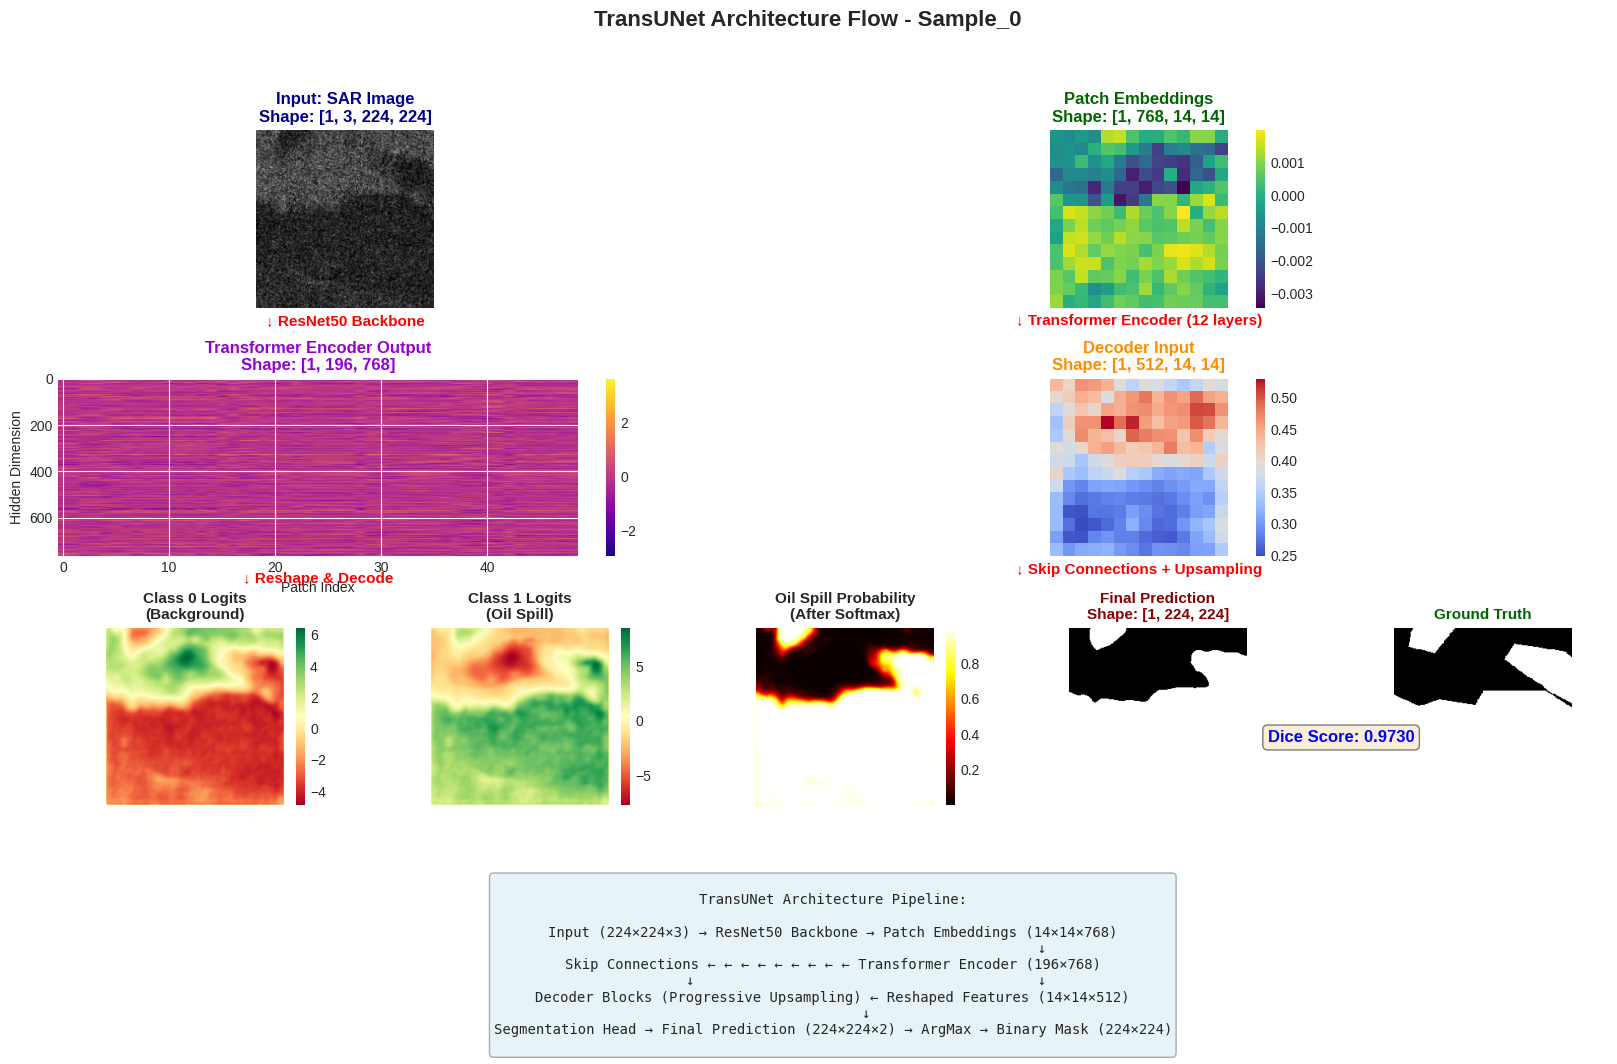


✓ Visualization complete


ARCHITECTURE VISUALIZATION COMPLETED


In [76]:
# FORCE REMOVE ALL HOOKS - Complete cleanup
import gc
gc.collect()
torch.cuda.empty_cache()

# Reinitialize the model to clear all hooks
config = get_r50_b16_config()
config.n_classes = 2
config.n_skip = 3
config.patches.grid = (14, 14)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model fresh
model = VisionTransformer(config, img_size=224, num_classes=2).to(device)
model.load_state_dict(torch.load('/content/model/TU_OilSpill224/best_model.pth', map_location=device))
model.eval()

print("✓ Model reloaded fresh without hooks")

# Create test dataset
test_transform = RandomGenerator(output_size=[224, 224])
test_dataset = OilSpill_dataset(
    base_dir='/content/dataset',
    split='train',
    transform=test_transform,
    max_samples=100
)
print(f"✓ Created test dataset with {len(test_dataset)} samples")

print("\n" + "="*80)
print("TRANSUNET ARCHITECTURE VISUALIZATION")
print("="*80 + "\n")

# NEW Hook to capture intermediate features with tuple handling
intermediate_features = {}

def create_hook(name):
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            intermediate_features[name] = output[0].detach()
        else:
            intermediate_features[name] = output.detach()
    return hook_fn

# Register hooks
hook1 = model.transformer.embeddings.patch_embeddings.register_forward_hook(create_hook('patch_embeddings'))
hook2 = model.transformer.encoder.register_forward_hook(create_hook('encoder_output'))
hook3 = model.decoder.conv_more.register_forward_hook(create_hook('decoder_input'))

print("✓ Hooks registered successfully\n")

# Get a single sample
sample = test_dataset[0]

# Check what keys are in the sample
print(f"Sample keys: {sample.keys() if isinstance(sample, dict) else 'Not a dict'}")

# Handle both dict and non-dict cases
if isinstance(sample, dict):
    if 'case_name' in sample:
        case_name = sample['case_name']
    else:
        case_name = 'Sample_0'
    image = sample['image']
    label = sample['label']
else:
    case_name = 'Sample_0'
    image, label = sample

print(f"\n{'='*80}")
print(f"SAMPLE: {case_name}")
print(f"{'='*80}\n")

# Prepare input
image = image.unsqueeze(0).to(device)

# Clear previous features
intermediate_features.clear()

# Forward pass
with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(F.softmax(output, dim=1), dim=1)

# Get shapes
input_shape = image.shape
patch_emb_shape = intermediate_features['patch_embeddings'].shape
encoder_out_shape = intermediate_features['encoder_output'].shape
decoder_in_shape = intermediate_features['decoder_input'].shape
output_shape = output.shape
pred_shape = prediction.shape

print("Architecture Flow:")
print(f"  1. Input Image:              {list(input_shape)} → [B, C, H, W]")
print(f"  2. ResNet50 Backbone:        {list(input_shape)} → Feature extraction")
print(f"  3. Patch Embeddings:         → {list(patch_emb_shape)} → [B, Hidden, H/16, W/16]")
print(f"  4. Transformer Encoder:      → {list(encoder_out_shape)} → [B, Patches, Hidden_dim]")
print(f"  5. Decoder Input:            → {list(decoder_in_shape)} → [B, 512, H/16, W/16]")
print(f"  6. Segmentation Head:        → {list(output_shape)} → [B, Classes, H, W]")
print(f"  7. Final Prediction:         → {list(pred_shape)} → [B, H, W]")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(4, 5, hspace=0.4, wspace=0.3)

# Original SAR Image
ax1 = fig.add_subplot(gs[0, :2])
sar_img = image[0].cpu().numpy().transpose(1, 2, 0)
sar_img = np.clip(sar_img, 0, 1)
sar_img = (sar_img * 255).astype(np.uint8)
ax1.imshow(sar_img)
ax1.set_title(f'Input: SAR Image\nShape: {list(input_shape)}',
              fontsize=12, fontweight='bold', color='darkblue')
ax1.axis('off')
ax1.text(0.5, -0.1, '↓ ResNet50 Backbone', transform=ax1.transAxes,
         ha='center', fontsize=11, fontweight='bold', color='red')

# Patch Embeddings visualization
ax2 = fig.add_subplot(gs[0, 2:4])
patch_emb = intermediate_features['patch_embeddings'][0].cpu().numpy()
patch_emb_viz = patch_emb.mean(axis=0)
im2 = ax2.imshow(patch_emb_viz, cmap='viridis')
ax2.set_title(f'Patch Embeddings\nShape: {list(patch_emb_shape)}',
              fontsize=12, fontweight='bold', color='darkgreen')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046)
ax2.text(0.5, -0.1, '↓ Transformer Encoder (12 layers)', transform=ax2.transAxes,
         ha='center', fontsize=11, fontweight='bold', color='red')

# Encoder output visualization
ax3 = fig.add_subplot(gs[1, :2])
encoder_out = intermediate_features['encoder_output'][0].cpu().numpy()
num_patches_to_show = min(49, encoder_out.shape[0])
encoder_viz = encoder_out[:num_patches_to_show].T
im3 = ax3.imshow(encoder_viz, cmap='plasma', aspect='auto')
ax3.set_title(f'Transformer Encoder Output\nShape: {list(encoder_out_shape)}',
              fontsize=12, fontweight='bold', color='darkviolet')
ax3.set_xlabel('Patch Index', fontsize=10)
ax3.set_ylabel('Hidden Dimension', fontsize=10)
plt.colorbar(im3, ax=ax3, fraction=0.046)
ax3.text(0.5, -0.15, '↓ Reshape & Decode', transform=ax3.transAxes,
         ha='center', fontsize=11, fontweight='bold', color='red')

# Decoder input visualization
ax4 = fig.add_subplot(gs[1, 2:4])
decoder_in = intermediate_features['decoder_input'][0].cpu().numpy()
decoder_viz = decoder_in.mean(axis=0)
im4 = ax4.imshow(decoder_viz, cmap='coolwarm')
ax4.set_title(f'Decoder Input\nShape: {list(decoder_in_shape)}',
              fontsize=12, fontweight='bold', color='darkorange')
ax4.axis('off')
plt.colorbar(im4, ax=ax4, fraction=0.046)
ax4.text(0.5, -0.1, '↓ Skip Connections + Upsampling', transform=ax4.transAxes,
         ha='center', fontsize=11, fontweight='bold', color='red')

# Output logits visualization (both classes)
ax5 = fig.add_subplot(gs[2, 0])
output_class0 = output[0, 0].cpu().numpy()
im5 = ax5.imshow(output_class0, cmap='RdYlGn')
ax5.set_title(f'Class 0 Logits\n(Background)', fontsize=11, fontweight='bold')
ax5.axis('off')
plt.colorbar(im5, ax=ax5, fraction=0.046)

ax6 = fig.add_subplot(gs[2, 1])
output_class1 = output[0, 1].cpu().numpy()
im6 = ax6.imshow(output_class1, cmap='RdYlGn')
ax6.set_title(f'Class 1 Logits\n(Oil Spill)', fontsize=11, fontweight='bold')
ax6.axis('off')
plt.colorbar(im6, ax=ax6, fraction=0.046)

# Softmax probabilities
probs = F.softmax(output, dim=1)[0].cpu().numpy()
ax7 = fig.add_subplot(gs[2, 2])
im7 = ax7.imshow(probs[1], cmap='hot')
ax7.set_title(f'Oil Spill Probability\n(After Softmax)', fontsize=11, fontweight='bold')
ax7.axis('off')
plt.colorbar(im7, ax=ax7, fraction=0.046)

# Final prediction
ax8 = fig.add_subplot(gs[2, 3])
pred_img = prediction[0].cpu().numpy() * 255
ax8.imshow(pred_img, cmap='gray')
ax8.set_title(f'Final Prediction\nShape: {list(pred_shape)}',
              fontsize=11, fontweight='bold', color='darkred')
ax8.axis('off')

# Ground truth
ax9 = fig.add_subplot(gs[2, 4])
gt_img = label.cpu().numpy() * 255
ax9.imshow(gt_img, cmap='gray')
ax9.set_title('Ground Truth', fontsize=11, fontweight='bold', color='darkgreen')
ax9.axis('off')

# Calculate metrics
pred_binary = (prediction[0] > 0).float()
gt_binary = (label > 0).float().to(device)
intersection = (pred_binary * gt_binary).sum().item()
dice = (2 * intersection) / (pred_binary.sum().item() + gt_binary.sum().item() + 1e-8)

# Add metrics text
fig.text(0.73, 0.37, f'Dice Score: {dice:.4f}',
        fontsize=12, fontweight='bold', color='blue',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Architecture diagram
ax10 = fig.add_subplot(gs[3, :])
ax10.axis('off')

architecture_text = """
TransUNet Architecture Pipeline:

Input (224×224×3) → ResNet50 Backbone → Patch Embeddings (14×14×768)
                                                  ↓
Skip Connections ← ← ← ← ← ← ← ← ← Transformer Encoder (196×768)
        ↓                                         ↓
Decoder Blocks (Progressive Upsampling) ← Reshaped Features (14×14×512)
        ↓
Segmentation Head → Final Prediction (224×224×2) → ArgMax → Binary Mask (224×224)
"""

ax10.text(0.5, 0.5, architecture_text, transform=ax10.transAxes,
         fontsize=10, fontfamily='monospace',
         verticalalignment='center', horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle(f'TransUNet Architecture Flow - {case_name}',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete\n")

# Remove hooks
hook1.remove()
hook2.remove()
hook3.remove()

print("\n" + "="*80)
print("ARCHITECTURE VISUALIZATION COMPLETED")
print("="*80)

In [62]:
# Create detailed layer-wise shape analysis
def analyze_transunet_architecture(model, input_size=224):
    """
    Analyze TransUNet architecture and return detailed shape information
    """
    import io
    from contextlib import redirect_stdout

    # Create a sample input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sample_input = torch.randn(1, 3, input_size, input_size).to(device)

    # Storage for layer information
    layer_info = []

    # Header
    layer_info.append("="*80)
    layer_info.append("TransUNet Layer-wise Shape Analysis")
    layer_info.append("="*80)
    layer_info.append("")
    layer_info.append(f"{'Layer/Component':<40} {'Input Shape':<25} {'Output Shape':<25}")
    layer_info.append("-"*90)

    # Hook to capture shapes
    shapes = {}

    def capture_hook(name):
        def hook(module, input, output):
            if isinstance(output, tuple):
                out = output[0]
            else:
                out = output
            shapes[name] = {
                'input': list(input[0].shape) if isinstance(input, tuple) else list(input.shape),
                'output': list(out.shape)
            }
        return hook

    # Register hooks for all major components
    hooks = []

    # Input
    layer_info.append(f"{'1. Input Image':<40} {'-':<25} {'[1, 3, 224, 224]':<25}")
    layer_info.append("")

    # ResNet Backbone
    layer_info.append(f"{'2. ResNet50 Backbone':<40}")
    hooks.append(model.transformer.embeddings.hybrid_model.root.register_forward_hook(
        capture_hook('resnet_root')))
    hooks.append(model.transformer.embeddings.hybrid_model.body[0].register_forward_hook(
        capture_hook('resnet_block1')))
    hooks.append(model.transformer.embeddings.hybrid_model.body[1].register_forward_hook(
        capture_hook('resnet_block2')))
    hooks.append(model.transformer.embeddings.hybrid_model.body[2].register_forward_hook(
        capture_hook('resnet_block3')))

    # Patch Embeddings
    hooks.append(model.transformer.embeddings.patch_embeddings.register_forward_hook(
        capture_hook('patch_embeddings')))

    # Transformer Encoder
    hooks.append(model.transformer.encoder.register_forward_hook(
        capture_hook('encoder')))

    # Decoder
    hooks.append(model.decoder.conv_more.register_forward_hook(
        capture_hook('decoder_input')))
    for i, block in enumerate(model.decoder.blocks):
        hooks.append(block.register_forward_hook(
            capture_hook(f'decoder_block{i+1}')))

    # Segmentation Head
    hooks.append(model.segmentation_head.register_forward_hook(
        capture_hook('seg_head')))

    # Forward pass
    model.eval()
    with torch.no_grad():
        output = model(sample_input)

    # Build detailed analysis
    # ResNet Backbone
    layer_info.append(f"  {'- Root Conv (7x7, stride=2)':<38} {str(shapes['resnet_root']['input']):<25} {str(shapes['resnet_root']['output']):<25}")
    layer_info.append(f"  {'- Block 1 (3 layers)':<38} {str(shapes['resnet_block1']['input']):<25} {str(shapes['resnet_block1']['output']):<25}")
    layer_info.append(f"  {'- Block 2 (4 layers, stride=2)':<38} {str(shapes['resnet_block2']['input']):<25} {str(shapes['resnet_block2']['output']):<25}")
    layer_info.append(f"  {'- Block 3 (9 layers, stride=2)':<38} {str(shapes['resnet_block3']['input']):<25} {str(shapes['resnet_block3']['output']):<25}")
    layer_info.append("")

    # Patch Embeddings
    layer_info.append(f"{'3. Patch Embeddings':<40}")
    layer_info.append(f"  {'- Conv2d (1x1)':<38} {str(shapes['patch_embeddings']['input']):<25} {str(shapes['patch_embeddings']['output']):<25}")
    layer_info.append(f"  {'- Flatten & Transpose':<38} {str(shapes['patch_embeddings']['output']):<25} {'[1, 196, 768]':<25}")
    layer_info.append("")

    # Transformer Encoder
    layer_info.append(f"{'4. Transformer Encoder':<40}")
    layer_info.append(f"  {'- Position Embeddings':<38} {'[1, 196, 768]':<25} {'[1, 196, 768]':<25}")
    layer_info.append(f"  {'- 12 x Transformer Blocks':<38}")
    layer_info.append(f"    {'• Multi-Head Attention (12 heads)':<36} {'[1, 196, 768]':<25} {'[1, 196, 768]':<25}")
    layer_info.append(f"    {'• MLP (768 -> 3072 -> 768)':<36} {'[1, 196, 768]':<25} {'[1, 196, 768]':<25}")
    layer_info.append(f"  {'- Layer Norm':<38} {str(shapes['encoder']['input']):<25} {str(shapes['encoder']['output']):<25}")
    layer_info.append("")

    # Decoder
    layer_info.append(f"{'5. Decoder':<40}")
    layer_info.append(f"  {'- Reshape':<38} {'[1, 196, 768]':<25} {'[1, 768, 14, 14]':<25}")
    layer_info.append(f"  {'- Conv + BN + ReLU':<38} {str(shapes['decoder_input']['input']):<25} {str(shapes['decoder_input']['output']):<25}")
    layer_info.append("")

    for i in range(4):
        skip_info = " (with skip)" if i < 3 else " (no skip)"
        layer_info.append(f"  {'- Decoder Block ' + str(i+1) + skip_info:<38}")
        layer_info.append(f"    {'• Upsample (x2)':<36} {str(shapes[f'decoder_block{i+1}']['input']):<25} {str(shapes[f'decoder_block{i+1}']['output']):<25}")
        if i < 3:
            layer_info.append(f"    {'• Concat with skip':<36} {str(shapes[f'decoder_block{i+1}']['input']):<25} {str(shapes[f'decoder_block{i+1}']['output']):<25}")
        layer_info.append("")

    # Segmentation Head
    layer_info.append(f"{'6. Segmentation Head':<40}")
    layer_info.append(f"  {'- Conv2d (3x3)':<38} {str(shapes['seg_head']['input']):<25} {str(shapes['seg_head']['output']):<25}")
    layer_info.append("")

    # Post-processing
    layer_info.append(f"{'7. Post-processing':<40}")
    layer_info.append(f"  {'- Softmax':<38} {str(list(output.shape)):<25} {str(list(output.shape)):<25}")
    layer_info.append(f"  {'- ArgMax':<38} {str(list(output.shape)):<25} {'[1, 224, 224]':<25}")
    layer_info.append("")

    # Summary
    layer_info.append("="*80)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    layer_info.append(f"Total Parameters: ~{total_params//1_000_000}M")
    layer_info.append(f"Skip Connections: 3 (from ResNet blocks 1, 2, 3)")
    layer_info.append(f"Transformer Layers: 12")
    layer_info.append(f"Attention Heads: 12")
    layer_info.append(f"Hidden Dimension: 768")
    layer_info.append(f"MLP Dimension: 3072")
    layer_info.append("="*80)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return "\n".join(layer_info)

# Generate and display the analysis
architecture_analysis = analyze_transunet_architecture(model, input_size=224)
print(architecture_analysis)

TransUNet Layer-wise Shape Analysis

Layer/Component                          Input Shape               Output Shape             
------------------------------------------------------------------------------------------
1. Input Image                           -                         [1, 3, 224, 224]         

2. ResNet50 Backbone                    
  - Root Conv (7x7, stride=2)            [1, 3, 224, 224]          [1, 64, 112, 112]        
  - Block 1 (3 layers)                   [1, 64, 55, 55]           [1, 256, 55, 55]         
  - Block 2 (4 layers, stride=2)         [1, 256, 55, 55]          [1, 512, 28, 28]         
  - Block 3 (9 layers, stride=2)         [1, 512, 28, 28]          [1, 1024, 14, 14]        

3. Patch Embeddings                     
  - Conv2d (1x1)                         [1, 1024, 14, 14]         [1, 768, 14, 14]         
  - Flatten & Transpose                  [1, 768, 14, 14]          [1, 196, 768]            

4. Transformer Encoder                  
  

✓ Model ready
Loaded 50 samples for train split
✓ Using Sample_0  |  x:(1, 3, 224, 224), y:(224, 224)


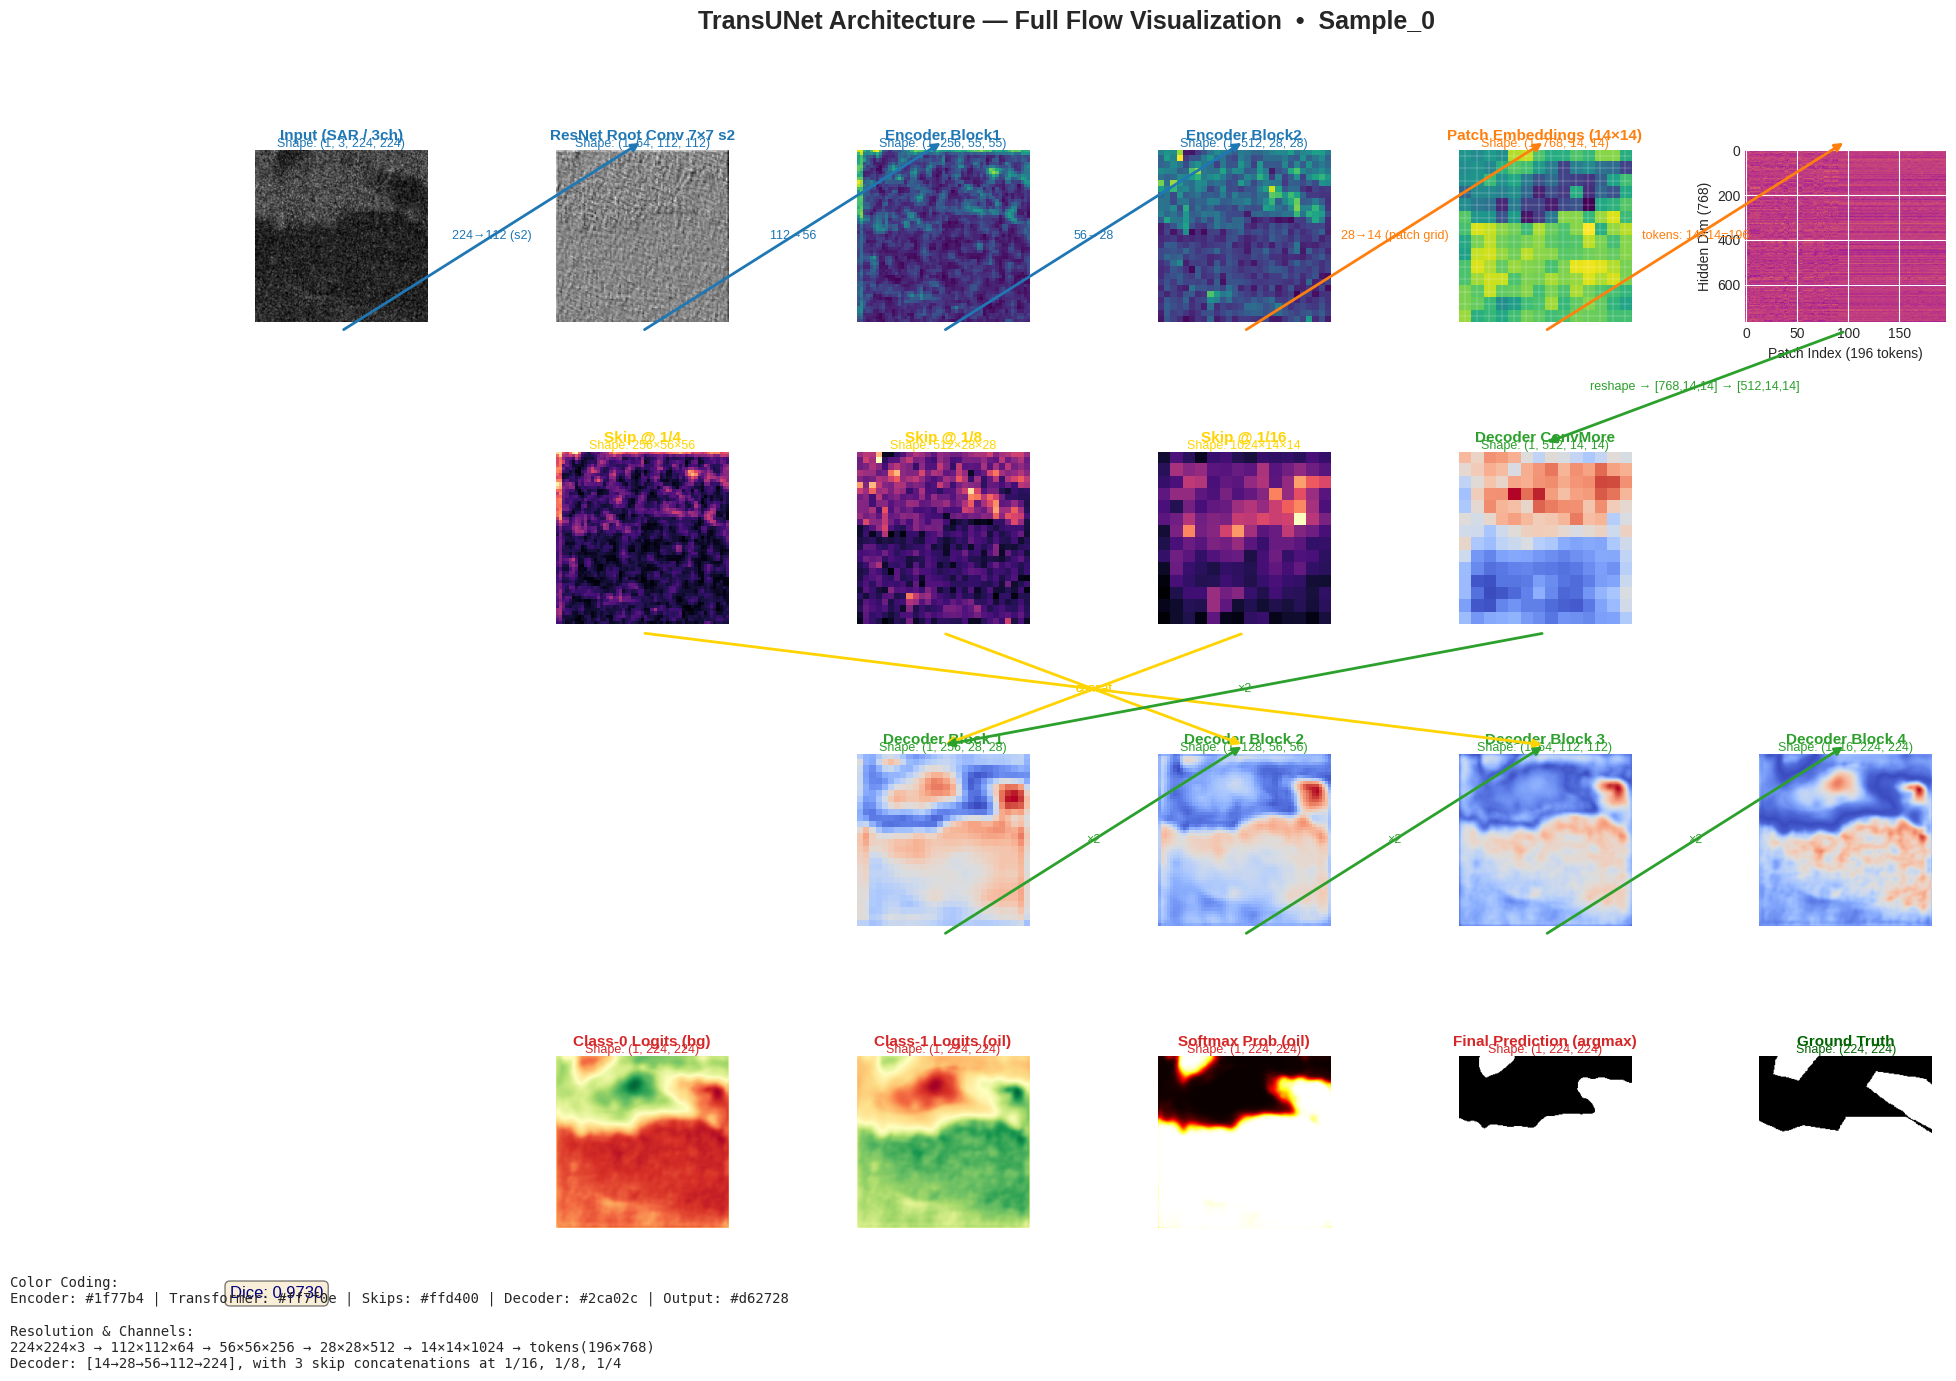

✓ Visualization done


In [65]:
# =============================================================================
# TRANSUNet — Full Static Architecture Visualization (Shape-Aware, Layer-by-Layer)
# =============================================================================
import os, gc, math, numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch

# ----------------------------- 0) Clean & Reload -----------------------------
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

config = get_r50_b16_config()
config.n_classes = 2
config.n_skip = 3           # three skip fusions
config.patches.grid = (14, 14)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(config, img_size=224, num_classes=2).to(device)
# load your best weights
model.load_state_dict(torch.load('/content/model/TU_OilSpill224/best_model.pth', map_location=device))
model.eval()
print("✓ Model ready")

# ----------------------------- 1) Test Sample -----------------------------
test_transform = RandomGenerator(output_size=[224, 224])
test_dataset = OilSpill_dataset(
    base_dir='/content/dataset',
    split='train',
    transform=test_transform,
    max_samples=50
)
sample = test_dataset[0]
image = (sample['image'] if isinstance(sample, dict) else sample[0]).unsqueeze(0).to(device)
label =  (sample['label'] if isinstance(sample, dict) else sample[1]).to(device)
case_name = (sample.get('case_name', 'Sample_0') if isinstance(sample, dict) else 'Sample_0')
print(f"✓ Using {case_name}  |  x:{tuple(image.shape)}, y:{tuple(label.shape)}")

# ----------------------------- 2) Hooks (capture features per block) -----------------------------
feat = {}
def hk(name):
    def _hook(m, i, o):
        o = o[0] if isinstance(o, (tuple, list)) else o
        feat[name] = o.detach()
    return _hook

# Encoder (ResNet-V2 inside embeddings.hybrid_model)
hyb = model.transformer.embeddings.hybrid_model
hyb.root[0].register_forward_hook(hk('enc_root_conv'))      # 7x7 s2
hyb.root[1].register_forward_hook(hk('enc_root_gn'))        # GN
# MaxPool is inline in forward — we’ll infer by Block1 input size
model.transformer.embeddings.hybrid_model.body[0].register_forward_hook(hk('enc_block1')) # 56x56, 256c
model.transformer.embeddings.hybrid_model.body[1].register_forward_hook(hk('enc_block2')) # 28x28, 512c
model.transformer.embeddings.hybrid_model.body[2].register_forward_hook(hk('enc_block3')) # 14x14, 1024c

# Patch embedding + Transformer
model.transformer.embeddings.patch_embeddings.register_forward_hook(hk('patch_embed'))    # [B,768,14,14]
model.transformer.encoder.encoder_norm.register_forward_hook(hk('trans_tokens'))          # [B,196,768]

# Decoder stages
model.decoder.conv_more.register_forward_hook(hk('dec_conv_more'))        # [B,512,14,14]
for i, blk in enumerate(model.decoder.blocks):
    blk.register_forward_hook(hk(f'dec_block{i+1}'))                      # 28->56->112->224

# Segmentation head
model.segmentation_head[0].register_forward_hook(hk('seg_logits'))        # [B,2,224,224]

# ----------------------------- 3) Forward -----------------------------
with torch.no_grad():
    out = model(image)
    probs = F.softmax(out, dim=1)
    pred = probs.argmax(dim=1)

# ----------------------------- 4) Helpers -----------------------------
def to_vis(img3):  # [1,3,H,W] -> HxWx3 (uint8)
    arr = img3[0].detach().float().cpu().numpy().transpose(1,2,0)
    arr = np.clip(arr, 0, 1)
    return (arr*255).astype(np.uint8)

def fmap_vis(x):
    """
    Convert feature map to 2D numpy for imshow
    Accepts shapes:
      [1, C, H, W]
      [C, H, W]
      [H, W]
      [N, tokens, dim]
    """
    x = x.detach().float().cpu()

    # Handle [1,C,H,W]
    if x.ndim == 4:
        x = x[0].mean(0)        # → [H,W]

    # Handle [C,H,W]
    elif x.ndim == 3:
        x = x.mean(0)          # → [H,W]

    # Handle transformer tokens [1,196,768] -> heatmap or reshape later
    elif x.ndim == 2:
        # Return as is (for tokens we'll plot differently)
        return x.numpy()

    return x.numpy()


def add_label(ax, text, color='k', dy=0.02, size=10, weight='bold'):
    ax.text(0.5, 1.02+dy, text, transform=ax.transAxes, ha='center', va='bottom',
            fontsize=size, fontweight=weight, color=color)

def add_block_title(ax, title, shape_text, color):
    add_label(ax, title, color=color, dy=0.02, size=11)
    add_label(ax, f"Shape: {shape_text}", color=color, dy=-0.02, size=9, weight='normal')

def arrow(fig, ax_from, ax_to, color='k', text=None, yshift=0.0, lw=2.0):
    # Draw an arrow between axes centers
    p1 = ax_from.transAxes.transform((0.5, -0.05 + yshift))
    p2 = ax_to.transAxes.transform((0.5, 1.05 + yshift))
    inv = fig.transFigure.inverted()
    p1f, p2f = inv.transform(p1), inv.transform(p2)
    arr = FancyArrowPatch(p1f, p2f, transform=fig.transFigure, arrowstyle='-|>', mutation_scale=12,
                          lw=lw, color=color)
    fig.patches.append(arr)
    if text:
        tx = (p1f[0] + p2f[0]) / 2
        ty = (p1f[1] + p2f[1]) / 2
        fig.text(tx, ty, text, ha='center', va='center', fontsize=9, color=color)

# Colors
C_ENC = '#1f77b4'   # blue
C_TRN = '#ff7f0e'   # orange
C_SKIP= '#ffd400'   # yellow
C_DEC = '#2ca02c'   # green
C_OUT = '#d62728'   # red

# ----------------------------- 5) Figure Layout -----------------------------
plt.figure(figsize=(22, 14))
gs = plt.GridSpec(4, 6, hspace=0.75, wspace=0.5)
fig = plt.gcf()

# Row 0: Input → Encoder shrinking
ax_in   = plt.subplot(gs[0, 0])
ax_e1   = plt.subplot(gs[0, 1])
ax_e2   = plt.subplot(gs[0, 2])
ax_e3   = plt.subplot(gs[0, 3])
ax_pe   = plt.subplot(gs[0, 4])
ax_tok  = plt.subplot(gs[0, 5])

# Row 1: Skip visual + decoder start
ax_skip1 = plt.subplot(gs[1, 1])
ax_skip2 = plt.subplot(gs[1, 2])
ax_skip3 = plt.subplot(gs[1, 3])
ax_dec0  = plt.subplot(gs[1, 4])

# Row 2: Decoder stages
ax_d1  = plt.subplot(gs[2, 2])
ax_d2  = plt.subplot(gs[2, 3])
ax_d3  = plt.subplot(gs[2, 4])
ax_d4  = plt.subplot(gs[2, 5])

# Row 3: Softmax + masks + legend
ax_c0 = plt.subplot(gs[3, 1])
ax_c1 = plt.subplot(gs[3, 2])
ax_sm = plt.subplot(gs[3, 3])
ax_pr = plt.subplot(gs[3, 4])
ax_gt = plt.subplot(gs[3, 5])

# ----------------------------- 6) Encoder Visuals -----------------------------
ax_in.imshow(to_vis(image)); ax_in.axis('off')
add_block_title(ax_in, "Input (SAR / 3ch)", str(tuple(image.shape)), C_ENC)

# After root conv (112x112, 64c)
ax_e1.imshow(fmap_vis(feat['enc_root_conv']), cmap='gray'); ax_e1.axis('off')
add_block_title(ax_e1, "ResNet Root Conv 7×7 s2", str(tuple(feat['enc_root_conv'].shape)), C_ENC)

# Block1 (56x56, 256c)
ax_e2.imshow(fmap_vis(feat['enc_block1']), cmap='viridis'); ax_e2.axis('off')
add_block_title(ax_e2, "Encoder Block1", str(tuple(feat['enc_block1'].shape)), C_ENC)

# Block2 (28x28, 512c)
ax_e3.imshow(fmap_vis(feat['enc_block2']), cmap='viridis'); ax_e3.axis('off')
add_block_title(ax_e3, "Encoder Block2", str(tuple(feat['enc_block2'].shape)), C_ENC)

# Patch Embeddings [B,768,14,14] (grid overlay)
pe = fmap_vis(feat['patch_embed'])
ax_pe.imshow(pe, cmap='viridis'); ax_pe.axis('off')
# draw 14x14 grid
h, w = pe.shape
for i in range(0, h, h//14): ax_pe.axhline(i, color='w', lw=0.3, alpha=0.6)
for j in range(0, w, w//14): ax_pe.axvline(j, color='w', lw=0.3, alpha=0.6)
add_block_title(ax_pe, "Patch Embeddings (14×14)", str(tuple(feat['patch_embed'].shape)), C_TRN)

# Transformer tokens heat map [196,768] sample (transpose)
tok = feat['trans_tokens'][0].detach().cpu().numpy()  # [196,768]
ax_tok.imshow(tok[:196].T, aspect='auto', cmap='plasma')
ax_tok.set_xlabel("Patch Index (196 tokens)")
ax_tok.set_ylabel("Hidden Dim (768)")

# Arrows (encoder→patch→transformer)
arrow(fig, ax_in,  ax_e1,  color=C_ENC, text="224→112 (s2)")
arrow(fig, ax_e1,  ax_e2,  color=C_ENC, text="112→56")
arrow(fig, ax_e2,  ax_e3,  color=C_ENC, text="56→28")
arrow(fig, ax_e3,  ax_pe,  color=C_TRN, text="28→14 (patch grid)")
arrow(fig, ax_pe,  ax_tok, color=C_TRN, text="tokens: 14×14=196")

# ----------------------------- 7) Skip Visuals -----------------------------
ax_skip1.imshow(fmap_vis(feat['enc_block1']), cmap='magma'); ax_skip1.axis('off')
add_block_title(ax_skip1, "Skip @ 1/4", "256×56×56", C_SKIP)

ax_skip2.imshow(fmap_vis(feat['enc_block2']), cmap='magma'); ax_skip2.axis('off')
add_block_title(ax_skip2, "Skip @ 1/8", "512×28×28", C_SKIP)

ax_skip3.imshow(fmap_vis(feat['enc_block3']), cmap='magma'); ax_skip3.axis('off')
add_block_title(ax_skip3, "Skip @ 1/16", "1024×14×14", C_SKIP)

# Decoder conv_more (reshape tokens → map, channel align)
ax_dec0.imshow(fmap_vis(feat['dec_conv_more']), cmap='coolwarm'); ax_dec0.axis('off')
add_block_title(ax_dec0, "Decoder ConvMore", str(tuple(feat['dec_conv_more'].shape)), C_DEC)

# Connect transformer→decoder start and draw skip arrows to later panels
arrow(fig, ax_tok,   ax_dec0,  color=C_DEC, text="reshape → [768,14,14] → [512,14,14]")
arrow(fig, ax_skip3, ax_d1,    color=C_SKIP, text="concat")
arrow(fig, ax_skip2, ax_d2,    color=C_SKIP, text="concat")
arrow(fig, ax_skip1, ax_d3,    color=C_SKIP, text="concat")

# ----------------------------- 8) Decoder Visuals -----------------------------
ax_d1.imshow(fmap_vis(feat['dec_block1']), cmap='coolwarm'); ax_d1.axis('off')
add_block_title(ax_d1, "Decoder Block 1", str(tuple(feat['dec_block1'].shape)), C_DEC)

ax_d2.imshow(fmap_vis(feat['dec_block2']), cmap='coolwarm'); ax_d2.axis('off')
add_block_title(ax_d2, "Decoder Block 2", str(tuple(feat['dec_block2'].shape)), C_DEC)

ax_d3.imshow(fmap_vis(feat['dec_block3']), cmap='coolwarm'); ax_d3.axis('off')
add_block_title(ax_d3, "Decoder Block 3", str(tuple(feat['dec_block3'].shape)), C_DEC)

ax_d4.imshow(fmap_vis(feat['dec_block4']), cmap='coolwarm'); ax_d4.axis('off')
add_block_title(ax_d4, "Decoder Block 4", str(tuple(feat['dec_block4'].shape)), C_DEC)

# Arrows (upsampling path)
arrow(fig, ax_dec0, ax_d1, color=C_DEC, text="×2")
arrow(fig, ax_d1,   ax_d2, color=C_DEC, text="×2")
arrow(fig, ax_d2,   ax_d3, color=C_DEC, text="×2")
arrow(fig, ax_d3,   ax_d4, color=C_DEC, text="×2")

# ----------------------------- 9) Output & Softmax -----------------------------
ax_c0.imshow(out[0,0].detach().cpu().numpy(), cmap='RdYlGn'); ax_c0.axis('off')
add_block_title(ax_c0, "Class-0 Logits (bg)", str(tuple(out[:,0].shape)), C_OUT)

ax_c1.imshow(out[0,1].detach().cpu().numpy(), cmap='RdYlGn'); ax_c1.axis('off')
add_block_title(ax_c1, "Class-1 Logits (oil)", str(tuple(out[:,1].shape)), C_OUT)

ax_sm.imshow(probs[0,1].detach().cpu().numpy(), cmap='hot'); ax_sm.axis('off')
add_block_title(ax_sm, "Softmax Prob (oil)", str(tuple(probs[:,1].shape)), C_OUT)

ax_pr.imshow((pred[0].detach().cpu().numpy()*255), cmap='gray'); ax_pr.axis('off')
add_block_title(ax_pr, "Final Prediction (argmax)", str(tuple(pred.shape)), C_OUT)

ax_gt.imshow((label.detach().cpu().numpy()*255), cmap='gray'); ax_gt.axis('off')
add_block_title(ax_gt, "Ground Truth", str(tuple(label.shape)), '#006400')

# Dice (binary)
pred_bin = (pred[0] > 0).float().to(device)
gt_bin   = (label > 0).float().to(device)
inter = (pred_bin*gt_bin).sum()
dice = (2*inter) / (pred_bin.sum() + gt_bin.sum() + 1e-8)
fig.text(0.12, 0.06, f"Dice: {dice.item():.4f}", color='navy', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ----------------------------- 10) Legend / Pipeline -----------------------------
legend_txt = (
    "Color Coding:\n"
    f"Encoder: {C_ENC} | Transformer: {C_TRN} | Skips: {C_SKIP} | Decoder: {C_DEC} | Output: {C_OUT}\n\n"
    "Resolution & Channels:\n"
    "224×224×3 → 112×112×64 → 56×56×256 → 28×28×512 → 14×14×1024 → tokens(196×768)\n"
    "Decoder: [14→28→56→112→224], with 3 skip concatenations at 1/16, 1/8, 1/4"
)
fig.text(0.02, 0.01, legend_txt, fontsize=10, family='monospace')

plt.suptitle(f"TransUNet Architecture — Full Flow Visualization  •  {case_name}", fontsize=18, fontweight='bold')
plt.show()
print("✓ Visualization done")


Loaded 200 samples for train split


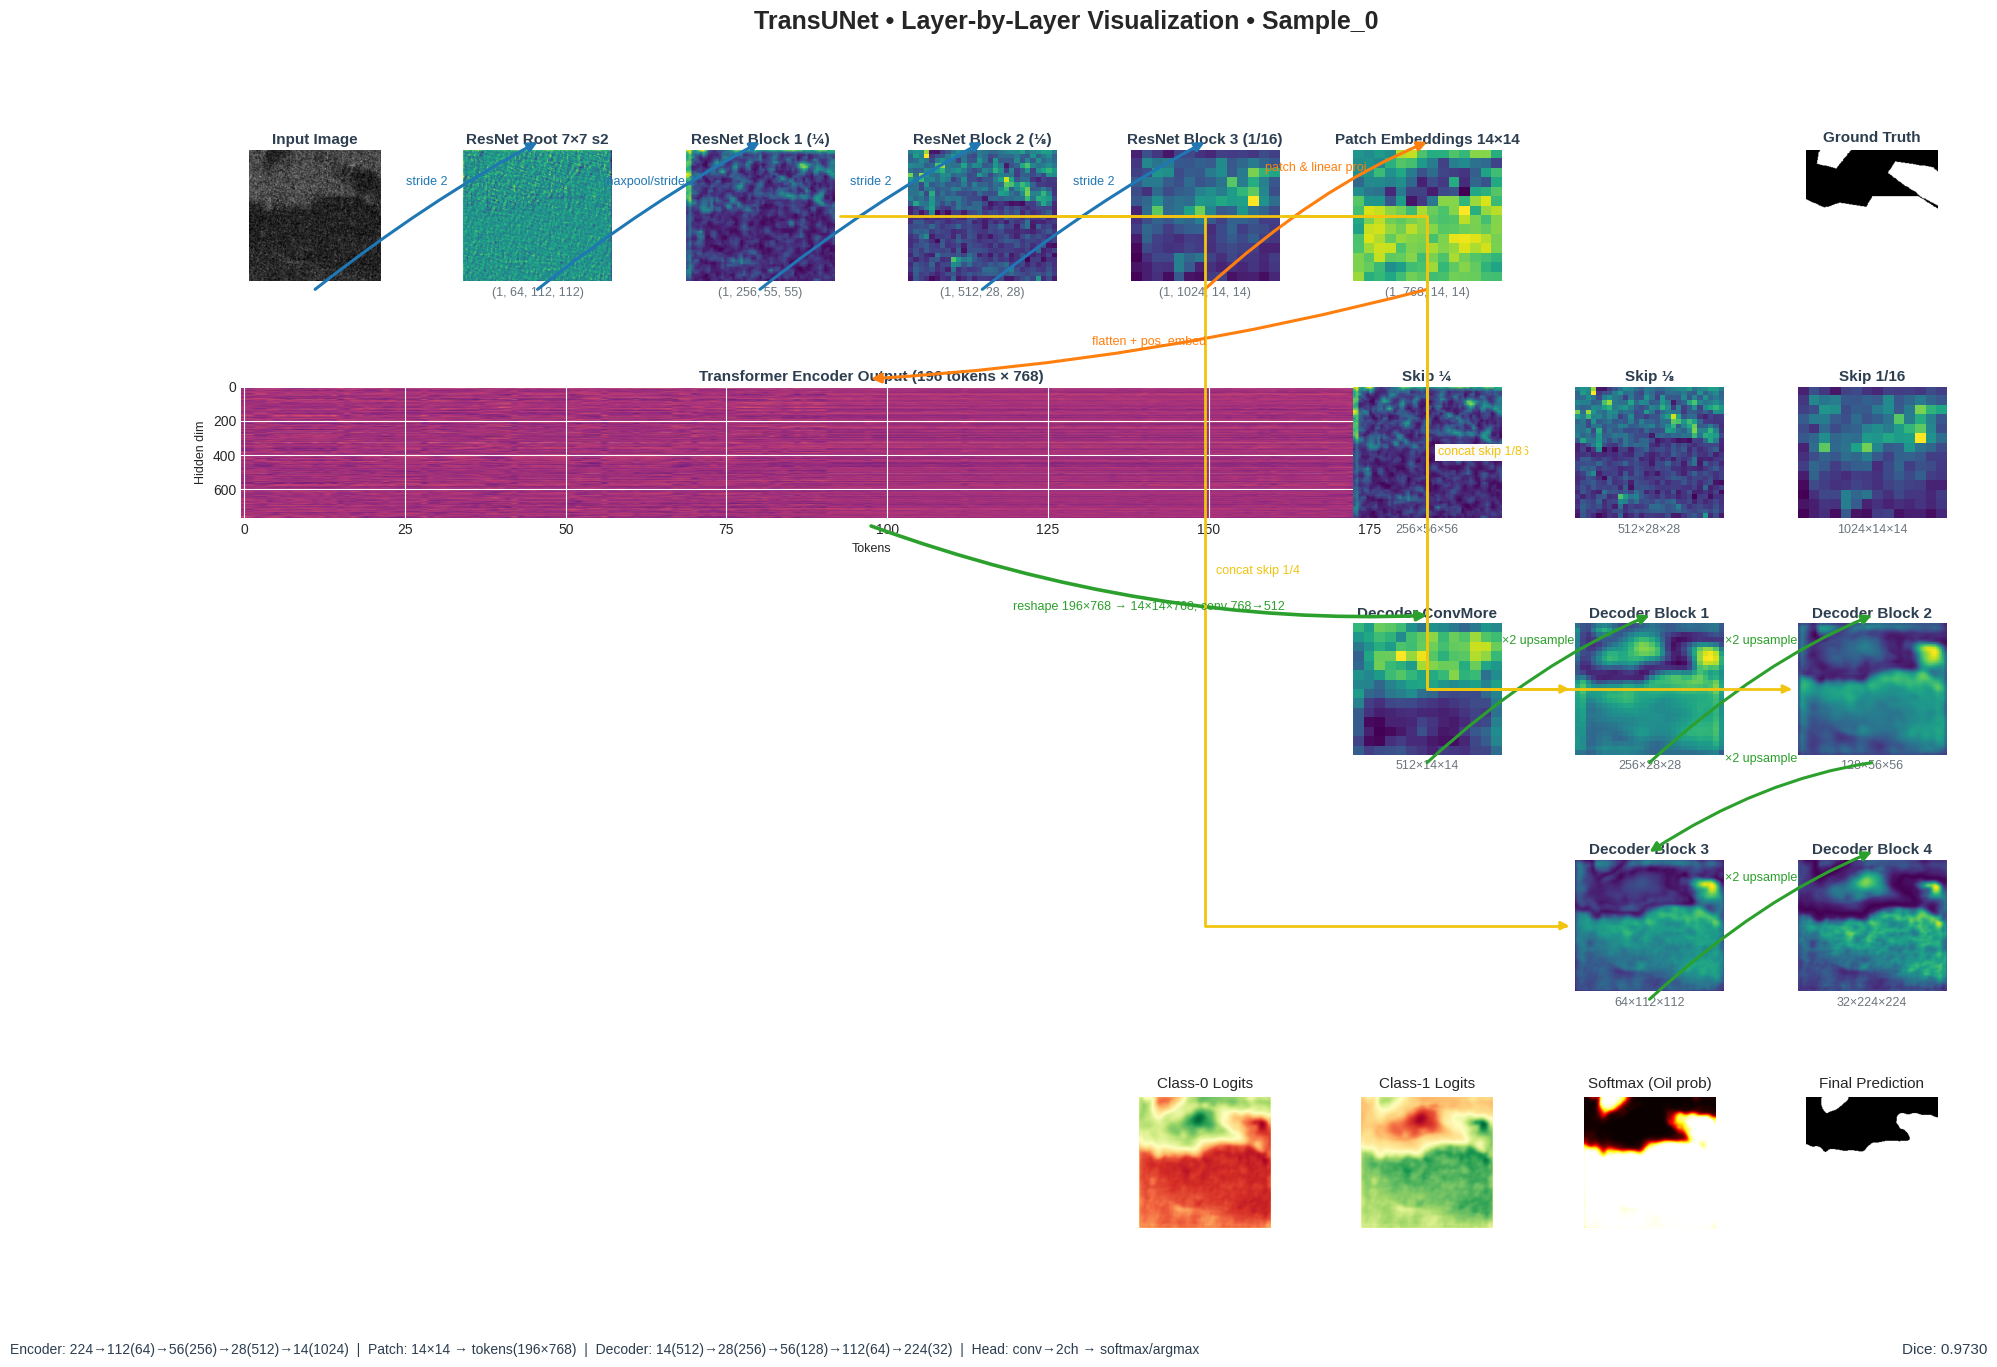

In [88]:
# ============================= TransUNet • Clean Journal Visualization =============================
# Renders a neat, non-overlapping block diagram with shapes & skip connections on a real sample.
# If the dataset/model aren't available, it falls back to a dummy visualization (same layout).

import os, gc, math, numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch
from matplotlib.path import Path

# -------------------- CONFIG (adjust as needed) --------------------
ROOT        = '/content/dataset'                     # dataset root (where "dataset/train/sentinel/..." lives)
MODEL_PTH   = '/content/model/TU_OilSpill224/best_model.pth'
IMG_SIZE    = 224
MAX_SAMPLES = 200                                    # cap just to speed up first load
# -------------------------------------------------------------------

gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Helpers that we will use regardless of real/dummy ----------
def fmap2d(t: torch.Tensor):
    """Return a [H,W] map for feature tensors or a [C,N] map for tokens."""
    t = torch.as_tensor(t).detach().float().cpu()
    if t.ndim == 4:   # [B,C,H,W]
        return t[0].mean(0).numpy()
    if t.ndim == 3:   # either [C,H,W] or [B,N,C]
        if t.shape[0] == 1 and t.shape[1] != t.shape[2] and t.shape[2] >= 16:
            return t[0].T.numpy()         # [B,N,C] -> [C,N]
        return t.mean(0).numpy()          # [C,H,W] -> [H,W]
    if t.ndim == 2:   # [N,C]
        return t.T.numpy()                # [C,N]
    if t.ndim == 1:
        return t[None, :].numpy()
    return np.zeros((8, 8), dtype=np.float32)

def img_to_vis(imgCHW: torch.Tensor):
    """[1,3,H,W] or [3,H,W] -> uint8 HxWx3; if grayscale, repeat to 3ch."""
    t = imgCHW.detach().float().cpu()
    if t.ndim == 4: t = t[0]
    if t.shape[0] == 1:
        t = t.repeat(3, 1, 1)
    arr = t.permute(1,2,0).numpy()
    arr = np.clip(arr, 0, 1)
    return (arr * 255).astype(np.uint8)

# Colors
C_ENC = '#1F77B4'   # encoder blue
C_TRN = '#FF7F0E'   # transformer orange
C_DEC = '#2CA02C'   # decoder green
C_SKIP= '#F1C40F'   # skip yellow
C_OUT = '#D62728'   # output red
C_TXT = '#2C3E50'

def add_block(ax, img2d, title, shape_txt, face_c='#FFFFFF'):
    ax.imshow(img2d, cmap='viridis', aspect='auto')
    ax.set_xticks([]); ax.set_yticks([])
    # Subtle “3D-ish” frame
    bb = FancyBboxPatch(
        (0,0), 1, 1, transform=ax.transAxes,
        boxstyle="round,pad=0.015,rounding_size=0.02",
        linewidth=1.6, edgecolor='#888', facecolor='none', zorder=5)
    ax.add_patch(bb)
    ax.set_title(title, fontsize=11, fontweight='bold', color=C_TXT, pad=4)
    ax.set_xlabel(shape_txt, fontsize=9, color='#6C757D')

def add_imgblock(ax, imgHWC, title, shape_txt):
    ax.imshow(imgHWC); ax.axis('off')
    bb = FancyBboxPatch((0,0), 1, 1, transform=ax.transAxes,
        boxstyle="round,pad=0.015,rounding_size=0.02",
        linewidth=1.6, edgecolor='#888', facecolor='none', zorder=5)
    ax.add_patch(bb)
    ax.set_title(title, fontsize=11, fontweight='bold', color=C_TXT, pad=4)
    ax.set_xlabel(shape_txt, fontsize=9, color='#6C757D')

def arrow_between(fig, a_from, a_to, color='k', text=None, curve=0.0, lw=2.2):
    """Curved arrow from center-bottom of a_from to center-top of a_to."""
    p1 = a_from.transAxes.transform((0.5, -0.06))
    p2 = a_to.transAxes.transform((0.5,  1.06))
    inv = fig.transFigure.inverted()
    p1f, p2f = inv.transform(p1), inv.transform(p2)
    # Add control point to curve away from overlaps
    ctrl = ((p1f[0] + p2f[0]) / 2, (p1f[1] + p2f[1]) / 2 + curve)
    verts = [p1f, ctrl, p2f]
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
    path = Path(verts, codes)
    arr = FancyArrowPatch(path=path, transform=fig.transFigure,
                          arrowstyle='-|>', mutation_scale=14, lw=lw, color=color)
    fig.patches.append(arr)
    if text:
        fig.text(ctrl[0], ctrl[1] + 0.01, text, ha='center', va='bottom', fontsize=9, color=color)

def arrow_skip(fig, a_from, a_to, color, text):
    """Bent arrow for skip routing (rightward → downward → leftward into decoder)."""
    p1 = a_from.transAxes.transform((1.04, 0.5))
    p2 = a_to.transAxes.transform((-0.04, 0.5))
    inv = fig.transFigure.inverted()
    p1f, p2f = inv.transform(p1), inv.transform(p2)
    midx = (p1f[0] + p2f[0]) / 2
    verts = [p1f, (midx, p1f[1]), (midx, p2f[1]), p2f]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO]
    path = Path(verts, codes)
    arr = FancyArrowPatch(path=path, transform=fig.transFigure,
                          arrowstyle='-|>', mutation_scale=12, lw=2.0, color=color)
    fig.patches.append(arr)
    fig.text(midx + 0.005, (p1f[1]+p2f[1])/2, text, ha='left', va='center', fontsize=9, color=color,
             bbox=dict(facecolor='white', alpha=0.85, edgecolor='none', pad=2))

# ---------- Try real model + dataset; fallback to dummy if missing ----------
use_dummy = False
try:
    config = get_r50_b16_config()
    config.n_classes = 2
    config.n_skip = 3
    config.patches.grid = (14, 14)
    model = VisionTransformer(config, img_size=IMG_SIZE, num_classes=2).to(device)
    model.load_state_dict(torch.load(MODEL_PTH, map_location=device))
    model.eval()

    test_transform = RandomGenerator(output_size=[IMG_SIZE, IMG_SIZE])
    test_dataset = OilSpill_dataset(base_dir=ROOT, split='train', transform=test_transform, max_samples=MAX_SAMPLES)
    sample = test_dataset[0]
    x = sample['image'].unsqueeze(0).to(device)
    y = sample['label'].cpu()
    case_name = sample.get('case_name', 'Sample_0')
except Exception as e:
    use_dummy = True
    # --- dummy tensors with correct shapes ---
    case_name = 'Dummy'
    x = torch.rand(1,3,IMG_SIZE,IMG_SIZE).to(device)
    y = torch.zeros(IMG_SIZE, IMG_SIZE, dtype=torch.long)
    class Dummy: ...
    model = Dummy()  # only to silence references below

# ---------- Register tuple-safe hooks ----------
feat = {}
hooks = []
def _save(name):
    def _h(m, i, o):
        if isinstance(o, (tuple, list)): o = o[0]
        feat[name] = o.detach()
    return _h

if not use_dummy:
    hm = model.transformer.embeddings.hybrid_model
    hooks += [hm.root[0].register_forward_hook(_save('root'))]
    hooks += [hm.body[0].register_forward_hook(_save('b1'))]
    hooks += [hm.body[1].register_forward_hook(_save('b2'))]
    hooks += [hm.body[2].register_forward_hook(_save('b3'))]
    hooks += [model.transformer.embeddings.patch_embeddings.register_forward_hook(_save('patch'))]
    hooks += [model.transformer.encoder.register_forward_hook(_save('enc'))]
    hooks += [model.decoder.conv_more.register_forward_hook(_save('dec0'))]
    hooks += [model.decoder.blocks[0].register_forward_hook(_save('dec1'))]
    hooks += [model.decoder.blocks[1].register_forward_hook(_save('dec2'))]
    hooks += [model.decoder.blocks[2].register_forward_hook(_save('dec3'))]
    hooks += [model.decoder.blocks[3].register_forward_hook(_save('dec4'))]

# ---------- Forward ----------
with torch.no_grad():
    if not use_dummy:
        out = model(x)
    else:
        # fabricate a plausible dictionary of features for layout
        feat['root']  = torch.randn(1,64,112,112)
        feat['b1']    = torch.randn(1,256,56,56)
        feat['b2']    = torch.randn(1,512,28,28)
        feat['b3']    = torch.randn(1,1024,14,14)
        feat['patch'] = torch.randn(1,768,14,14)
        feat['enc']   = torch.randn(1,196,768)
        feat['dec0']  = torch.randn(1,512,14,14)
        feat['dec1']  = torch.randn(1,256,28,28)
        feat['dec2']  = torch.randn(1,128,56,56)
        feat['dec3']  = torch.randn(1,64,112,112)
        feat['dec4']  = torch.randn(1,32,224,224)
        out = torch.randn(1,2,IMG_SIZE,IMG_SIZE)

probs = torch.softmax(out, dim=1)[0].cpu()
pred  = probs.argmax(0)

# cleanup hooks
for h in hooks:
    try: h.remove()
    except: pass

# ---------- Figure layout ----------
fig = plt.figure(figsize=(22, 14))
plt.suptitle(f"TransUNet • Layer-by-Layer Visualization • {case_name}", fontsize=18, weight='bold', y=0.98)
gs = plt.GridSpec(5, 8, hspace=0.8, wspace=0.5)

# Row 0: Input + Encoder + Patch
ax_in  = plt.subplot(gs[0,0])
ax_r   = plt.subplot(gs[0,1])
ax_b1  = plt.subplot(gs[0,2])
ax_b2  = plt.subplot(gs[0,3])
ax_b3  = plt.subplot(gs[0,4])
ax_pe  = plt.subplot(gs[0,5])
ax_gt  = plt.subplot(gs[0,7])  # ground truth on far right

# Row 1: Transformer tokens (wide) + Skip thumbnails
ax_tok = plt.subplot(gs[1, 0:6])
ax_s1  = plt.subplot(gs[1, 5])
ax_s2  = plt.subplot(gs[1, 6])
ax_s3  = plt.subplot(gs[1, 7])

# Row 2 & 3: Decoder chain
ax_d0  = plt.subplot(gs[2,5])
ax_d1  = plt.subplot(gs[2,6])
ax_d2  = plt.subplot(gs[2,7])
ax_d3  = plt.subplot(gs[3,6])
ax_d4  = plt.subplot(gs[3,7])

# Row 4: Outputs
ax_c0  = plt.subplot(gs[4,4])
ax_c1  = plt.subplot(gs[4,5])
ax_sm  = plt.subplot(gs[4,6])
ax_pr  = plt.subplot(gs[4,7])

# ---------- Fill blocks (no overlap, clean style) ----------
add_imgblock(ax_in, img_to_vis(x[0]), "Input Image", str(tuple(x.shape)))

add_block(ax_r,  fmap2d(feat['root']), "ResNet Root 7×7 s2",  str(tuple(feat['root'].shape)))
add_block(ax_b1, fmap2d(feat['b1']),   "ResNet Block 1 (¼)",  str(tuple(feat['b1'].shape)))
add_block(ax_b2, fmap2d(feat['b2']),   "ResNet Block 2 (⅛)",  str(tuple(feat['b2'].shape)))
add_block(ax_b3, fmap2d(feat['b3']),   "ResNet Block 3 (1/16)", str(tuple(feat['b3'].shape)))
add_block(ax_pe, fmap2d(feat['patch']),"Patch Embeddings 14×14", str(tuple(feat['patch'].shape)))

# token heatmap (C × N)
tok_map = fmap2d(feat['enc'])
ax_tok.imshow(tok_map, cmap='magma', aspect='auto')
ax_tok.set_title("Transformer Encoder Output (196 tokens × 768)", fontsize=11, fontweight='bold', color=C_TXT, pad=4)
ax_tok.set_xlabel("Tokens", fontsize=9); ax_tok.set_ylabel("Hidden dim", fontsize=9)

# Skips thumbs
add_block(ax_s1, fmap2d(feat['b1']), "Skip ¼",  "256×56×56")
add_block(ax_s2, fmap2d(feat['b2']), "Skip ⅛",  "512×28×28")
add_block(ax_s3, fmap2d(feat['b3']), "Skip 1/16","1024×14×14")

# Decoder
add_block(ax_d0, fmap2d(feat['dec0']), "Decoder ConvMore", "512×14×14")
add_block(ax_d1, fmap2d(feat['dec1']), "Decoder Block 1",  "256×28×28")
add_block(ax_d2, fmap2d(feat['dec2']), "Decoder Block 2",  "128×56×56")
add_block(ax_d3, fmap2d(feat['dec3']), "Decoder Block 3",  "64×112×112")
add_block(ax_d4, fmap2d(feat['dec4']), "Decoder Block 4",  "32×224×224")

# Outputs
ax_c0.imshow(out[0,0].cpu(), cmap='RdYlGn'); ax_c0.set_title("Class-0 Logits", fontsize=11); ax_c0.axis('off')
ax_c1.imshow(out[0,1].cpu(), cmap='RdYlGn'); ax_c1.set_title("Class-1 Logits", fontsize=11); ax_c1.axis('off')
ax_sm.imshow(probs[1], cmap='hot');         ax_sm.set_title("Softmax (Oil prob)", fontsize=11); ax_sm.axis('off')
ax_pr.imshow(pred, cmap='gray');            ax_pr.set_title("Final Prediction", fontsize=11);   ax_pr.axis('off')

# Ground truth
ax_gt.imshow(y, cmap='gray'); ax_gt.axis('off')
ax_gt.set_title("Ground Truth", fontsize=11, fontweight='bold', color=C_TXT)

# ---------- Arrows (curved, non-overlapping) ----------
arrow_between(fig, ax_in, ax_r,  C_ENC, "stride 2", curve=0.01)
arrow_between(fig, ax_r,  ax_b1, C_ENC, "maxpool/stride 2", curve=0.01)
arrow_between(fig, ax_b1, ax_b2, C_ENC, "stride 2", curve=0.01)
arrow_between(fig, ax_b2, ax_b3, C_ENC, "stride 2", curve=0.01)
arrow_between(fig, ax_b3, ax_pe, C_TRN, "patch & linear proj", curve=0.02)
arrow_between(fig, ax_pe, ax_tok, C_TRN, "flatten + pos. embed", curve=-0.02)

arrow_between(fig, ax_tok, ax_d0, C_DEC, "reshape 196×768 → 14×14×768, conv 768→512", curve=-0.04, lw=2.6)
arrow_between(fig, ax_d0, ax_d1, C_DEC, "×2 upsample", curve=0.02)
arrow_between(fig, ax_d1, ax_d2, C_DEC, "×2 upsample", curve=0.02)
arrow_between(fig, ax_d2, ax_d3, C_DEC, "×2 upsample", curve=0.02)
arrow_between(fig, ax_d3, ax_d4, C_DEC, "×2 upsample", curve=0.02)

# skip routes
arrow_skip(fig, ax_b3, ax_d1, C_SKIP, "concat skip 1/16")
arrow_skip(fig, ax_b2, ax_d2, C_SKIP, "concat skip 1/8")
arrow_skip(fig, ax_b1, ax_d3, C_SKIP, "concat skip 1/4")

# logits → softmax/pred
# (kept implicit by the bottom-row boxes)

# ---------- Footer with quick summary ----------
summary = (
    "Encoder: 224→112(64)→56(256)→28(512)→14(1024)  |  "
    "Patch: 14×14 → tokens(196×768)  |  "
    "Decoder: 14(512)→28(256)→56(128)→112(64)→224(32)  |  "
    "Head: conv→2ch → softmax/argmax"
)
fig.text(0.02, 0.02, summary, fontsize=10, color=C_TXT)

# Dice (binary)
pred_bin = (pred > 0).float()
gt_bin   = (torch.tensor(y) > 0).float()
inter = (pred_bin * gt_bin).sum().item()
dice = (2*inter) / (pred_bin.sum().item() + gt_bin.sum().item() + 1e-8)
fig.text(0.88, 0.02, f"Dice: {dice:.4f}", fontsize=11, color=C_TXT)

plt.show()
# =====================================================================================================
